In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 이거 실행하고 다시 런타임 시작
# 한글 폰트
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf



Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (6,882 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

# 필요 라이브러리 설치 및 데이터 업로드

In [ ]:
!pip install datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 534 kB/s 
     |████████████████████████████████| 251 kB 10.6 MB/s 


## 필요 라이브러리 import

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import plotly.express as px
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold
sns.set(font='NaNumBarunGothic')



%matplotlib inline


## 데이터 불러오기

In [3]:
pdde_final = pd.read_csv('/content/drive/MyDrive/롯데멤버스_빅데이터경진대회/pdde_final.csv',encoding = 'cp949')
cop_final = pd.read_csv('/content/drive/MyDrive/롯데멤버스_빅데이터경진대회/cop_final.csv')
lpay_final = pd.read_csv('/content/drive/MyDrive/롯데멤버스_빅데이터경진대회/lpay_final.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## 데이터 전처리
- 날짜 파생변수 만들기(연, 월, 요일)
- 날씨 파생변수 만들기(일교차, 불쾌지수)
- 공휴일&기념일 파생변수 만들기(공휴일&기념일:1, 아닌 날:0)


In [4]:
def preprocess(df):
    #성별 남자 : 0, 여성 1
    #나이 : 20대 0 30대 1 40대 2 50대 3 60대 4 70대 5
    # df.replace({'ma_fem_dv': {"남성": 0, "여성": 1},
    #                   'ages': {"20대": 0,"30대": 1, "40대": 2, "50대": 3, "60대": 4, "70대": 5 }},inplace=True)
    #날짜 split
    df['de_dt'] = df['de_dt'].astype(str)
    df['de_dt'] = pd.to_datetime(df['de_dt'])
    df['year'] = df['de_dt'].apply(lambda x: x.year)
    df['month'] = df['de_dt'].apply(lambda x: x.month)
    df['요일'] = df['de_dt'].apply(lambda x: x.weekday())
    #일교차 생성
    df['일교차'] = df["최고기온(℃)"] - df["최저기온(℃)"]

    # 불쾌지수 생성
    df['불쾌지수'] = 9/5*df['평균기온(℃)']-0.55*(1-df['평균습도(%rh)']/100)*(9/5*df['평균기온(℃)']-26) + 32



    # 2020년 데이터 제외
    df = df[df['year']!=2020]
    df= df.reset_index(drop=True)



    #공휴일 생성 요일은 월:0, 화:1
    tmp = []
    # 주말
    for i in range(len(df)):
        if df['요일'][i]==5 or df['요일'][i]==6: # 주말이면
            tmp.append(df['de_dt'][i])
    # 21년도 기준 공휴일 & 기념일 & 대체휴일
    공휴일 = ['2021-01-01','2021-02-11','2021-02-12', '2021-02-13','2021-02-14','2021-03-01','2021-03-14','2021-05-05','2021-05-08','2021-06-06',
             '2021-08-15','2021-08-16','2021-09-20','2021-09-21','2021-09-22','2021-10-03','2021-10-04','2021-10-09','2021-10-11','2021-12-24','2021-12-25']

    tmp.extend(공휴일)

    tmp = list(set(tmp)) #중복제거

    holiday_anniversary = []
    for i in range(len(df)):
        if df['de_dt'][i] in tmp:
            holiday_anniversary.append(1)
        else:
            holiday_anniversary.append(0)

    df['holiday_anniversary'] = holiday_anniversary
    return df


In [5]:
# 데이터 전처리 함수 적용
pdde_final= preprocess(pdde_final)
cop_final= preprocess(cop_final)
lpay_final= preprocess(lpay_final)

In [6]:
pdde_final.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1,inplace=True)
cop_final.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1,inplace=True)
lpay_final.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

# 상품구매정보 시각화

In [7]:
# 상품 구매 고객은 26917명이고 결제건수는 4381743번이 일어났다.
print(f'pdde 이용건수 : {len(pdde_final)}')
print(f'pdde 이용 고객 수 : {len(pdde_final["cust"].unique())}')

pdde 이용건수 : 4381743
pdde 이용 고객 수 : 26917


In [8]:
pdde_final.columns

Index(['cust', 'ma_fem_dv', 'ages', 'zon_hlv', 'rct_no', 'chnl_dv', 'cop_c',
       'br_c', 'pd_c', 'de_dt', 'de_hr', 'buy_am', 'buy_ct', 'pd_nm',
       'clac_hlv_nm', 'clac_mcls_nm', 'zon_mcls', '날짜', '강수량(mm)', '평균기온(℃)',
       '최저기온(℃)', '최고기온(℃)', '평균습도(%rh)', '최저습도(%rh)', '일조합(hr)', '일사합(MJ/m2)',
       'year', 'month', '요일', '일교차', '불쾌지수', 'holiday_anniversary'],
      dtype='object')

## 가격별 상품 분석
- 상품 대분류 평균가 top 10
- 상품 중분류 평균가 top 10

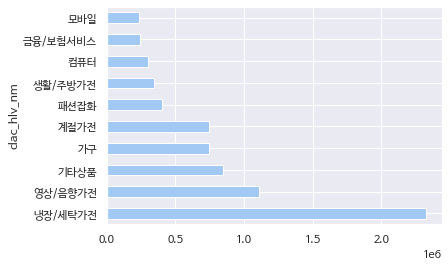

In [9]:
# 상품 대분류 평균가 top10
sns.set_palette('pastel')
pdde_final.groupby('clac_hlv_nm')['buy_am'].mean().sort_values(ascending=False).head(10).plot(kind = 'barh')

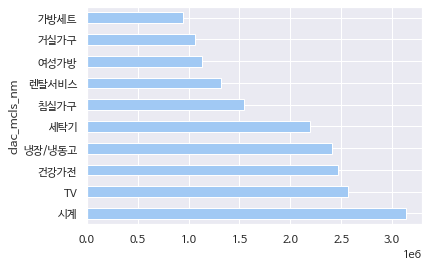

In [10]:
# 상품 중분류 평균가 top10
sns.set_palette('pastel')
pdde_final.groupby('clac_mcls_nm')['buy_am'].mean().sort_values(ascending=False).head(10).plot(kind = 'barh')

## 고객 기준별 구매건수 확인
- 연령대별 고객수 확인
- 성별별 고객수 확인
- 거주지별 고객수 확인

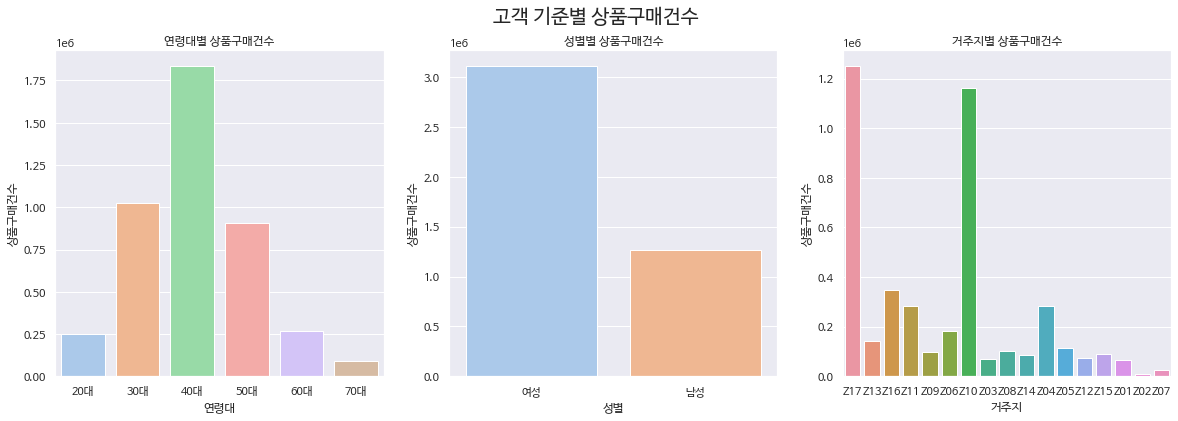

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(20,6))
sns.set_palette('pastel')
ax1= sns.countplot(x='ages',data = pdde_final,order = sorted(pdde_final['ages'].unique()), ax=axes[0] )
ax1.set_title('연령대별 상품구매건수')
ax1.set(xlabel='연령대', ylabel='상품구매건수')

ax2=sns.countplot(x='ma_fem_dv',data = pdde_final, ax=axes[1] )
ax2.set_title('성별별 상품구매건수')
ax2.set(xlabel='성별', ylabel='상품구매건수')

ax3=sns.countplot(x='zon_hlv',data = pdde_final, ax=axes[2] )
ax3.set_title('거주지별 상품구매건수')
ax3.set(xlabel='거주지', ylabel='상품구매건수')

plt.suptitle('고객 기준별 상품구매건수', fontsize=20)
plt.show()

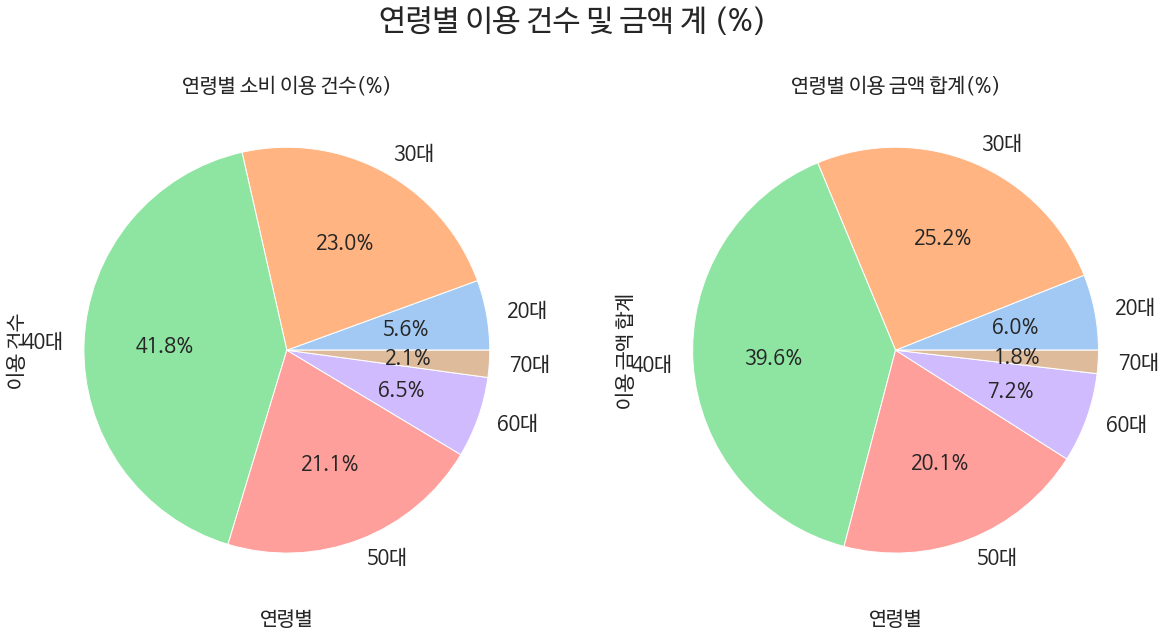

In [11]:
color = sns.color_palette('pastel')[:10]
a = pdde_final.groupby("ages")["buy_ct"].sum()
b= pdde_final.groupby("ages")["buy_am"].sum()

plt.figure(figsize = (20, 10))

plt.subplot(1,2,1)
plt.title("연령별 소비 이용 건수(%)", fontsize=20)

a.plot(kind = 'pie', autopct='%1.1f%%',textprops= {'fontsize' : 20}, colors = color)
plt.xlabel('연령별', fontsize=20)
plt.ylabel('이용 건수',fontsize=20)

plt.subplot(1,2,2)
plt.title("연령별 이용 금액 합계(%)", fontsize=20)

b.plot(kind = 'pie', autopct='%1.1f%%',textprops= {'fontsize' : 20}, colors = color)
plt.xlabel('연령별', fontsize=20)
plt.ylabel('이용 금액 합계', fontsize=20)

plt.suptitle('연령별 이용 건수 및 금액 계 (%)', fontsize = 30)
plt.show()

- 40대에서 빈번하게 상품 구매가 이루어졌다.
- 여성이 남성보다 더 빈번하게 쇼핑을 한다.

## 구매일자별 확인
- 연도는 2021년으로 고정돼있다.
- 월별 분석
- 요일별 분석(0이 월요일, 6이 일요일)

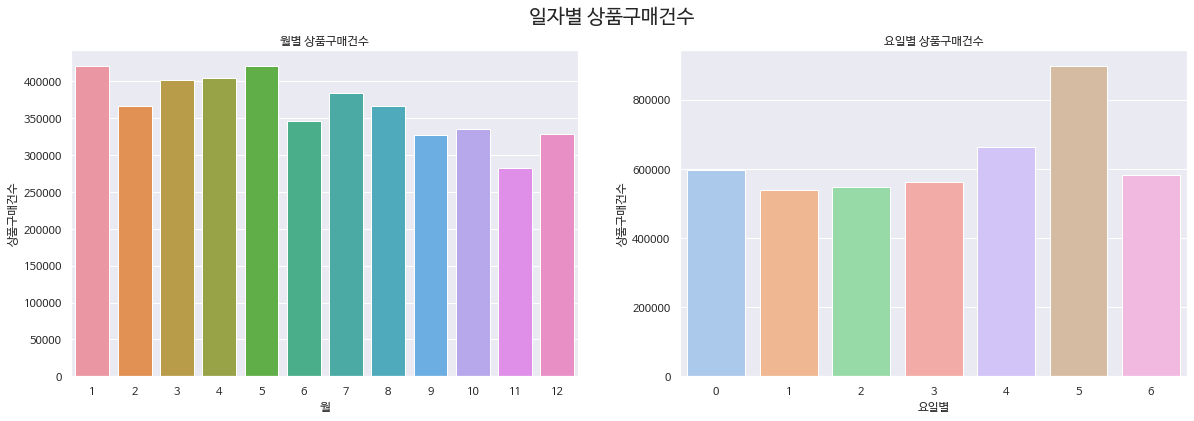

In [ ]:
# 일자별 상품구매건수 확인
fig, axes = plt.subplots(1,2,figsize=(20,6))
# ax1= sns.countplot(x='year',data = pdde,order = sorted(pdde['year'].unique()), ax=axes[0] )
# ax1.set_title('연도별 상품구매건수')
# ax1.set(xlabel='연도', ylabel='상품구매건수')

ax2=sns.countplot(x='month',data = pdde_final,order = sorted(pdde_final['month'].unique()), ax=axes[0] )
ax2.set_title('월별 상품구매건수')
ax2.set(xlabel='월', ylabel='상품구매건수')

ax3=sns.countplot(x='요일',data = pdde_final,order = sorted(pdde_final['요일'].unique()), ax=axes[1] )
ax3.set_title('요일별 상품구매건수')
ax3.set(xlabel='요일별', ylabel='상품구매건수')

plt.suptitle('일자별 상품구매건수', fontsize=20)
plt.show()

In [ ]:
pdde_final.head(3)

cust ma_fem_dv ages zon_hlv        rct_no  chnl_dv cop_c     br_c  \
0  M430112881        여성  50대     Z17  A01000001113        1   A01  A010039   
1  M646853852        여성  40대     Z13  A01000002265        1   A01  A010025   
2  M430112881        여성  50대     Z17  A01000003148        1   A01  A010039   

     pd_c                         de_dt  ...  평균습도(%rh)  최저습도(%rh)  일조합(hr)  \
0  PD0290 1970-01-01 00:00:00.020210101  ...         69         18      6.3   
1  PD1369 1970-01-01 00:00:00.020210101  ...         69         18      6.3   
2  PD0290 1970-01-01 00:00:00.020210101  ...         69         18      6.3   

  일사합(MJ/m2)  year month 요일   일교차      불쾌지수  holiday_anniversary  
0       8.82  1970     1  3  10.9  31.35646                    0  
1       8.82  1970     1  3  10.9  31.35646                    0  
2       8.82  1970     1  3  10.9  31.35646                    0  

[3 rows x 32 columns]

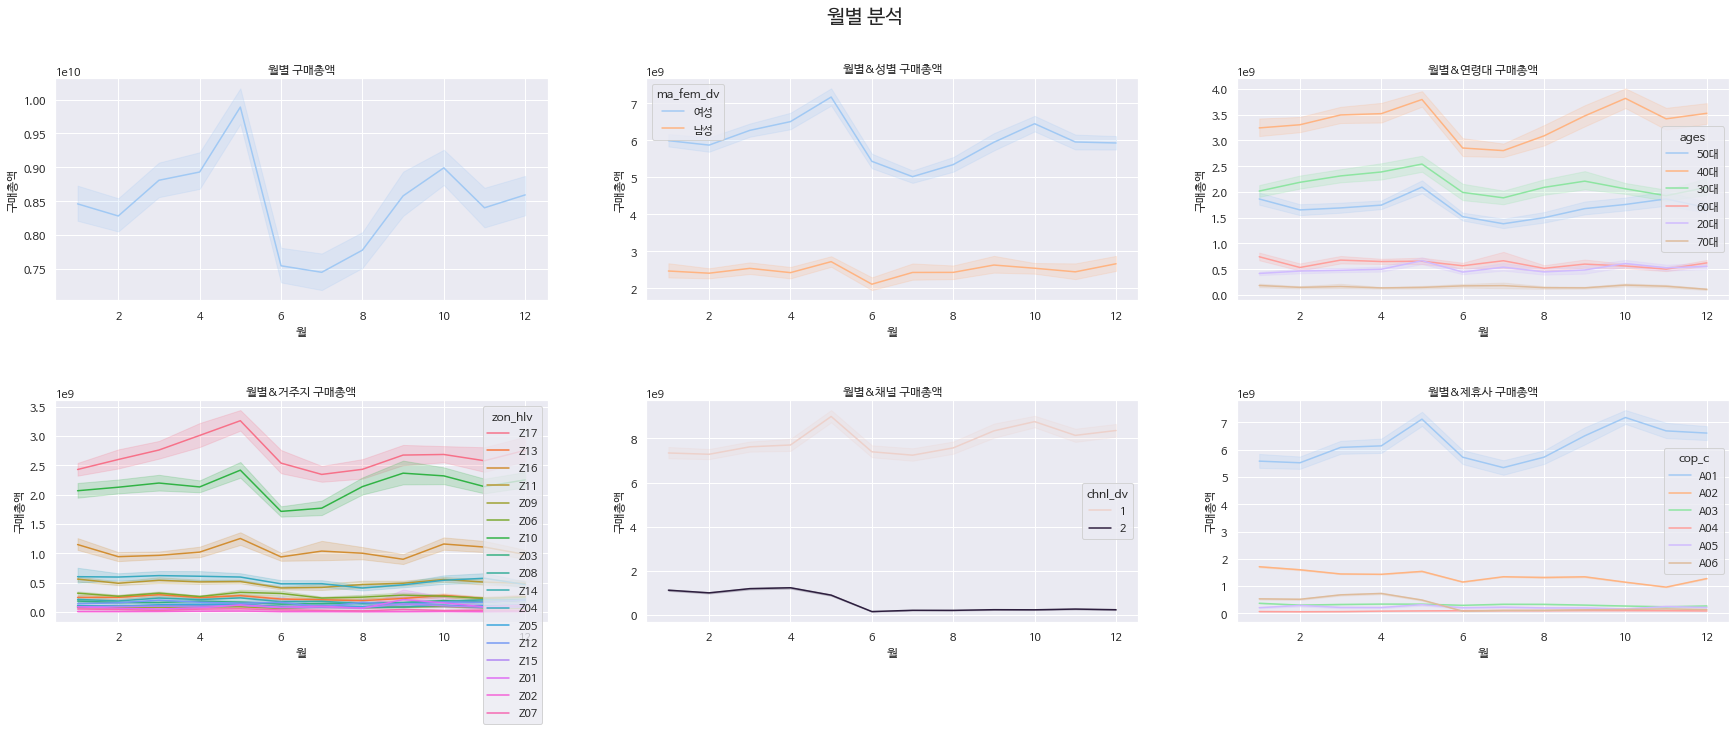

In [ ]:
# 월별 데이터 분석


fig, axes = plt.subplots(2,3,figsize=(30,10))
# 전체 매출액





ax1 = sns.lineplot(data = pdde_final
                ,x='month'
                ,y='buy_am'
                ,estimator=np.sum
                #,hue = 'ma_fem_dv'
                , ax = axes[0][0]
                          )
ax1.set_title('월별 구매총액')
ax1.set(xlabel='월', ylabel='구매총액')


# 성별별
ax2 = sns.lineplot(data = pdde_final
                ,x='month'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'ma_fem_dv'
                , ax = axes[0][1]
                          )
ax2.set_title('월별&성별 구매총액')
ax2.set(xlabel='월', ylabel='구매총액')

# 연령대별
ax3 = sns.lineplot(data = pdde_final
                ,x='month'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'ages'
                , ax = axes[0][2]
                          )
ax3.set_title('월별&연령대 구매총액')
ax3.set(xlabel='월', ylabel='구매총액')


# 거주지별
ax4 = sns.lineplot(data = pdde_final
                ,x='month'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'zon_hlv'
                , ax = axes[1][0]
                          )
ax4.set_title('월별&거주지 구매총액')
ax4.set(xlabel='월', ylabel='구매총액')

# 채널별
ax5 = sns.lineplot(data = pdde_final
                ,x='month'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'chnl_dv'
                , ax = axes[1][1]
                          )
ax5.set_title('월별&채널 구매총액')
ax5.set(xlabel='월', ylabel='구매총액')


# 제휴사별
ax6 = sns.lineplot(data = pdde_final
                ,x='month'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'cop_c'
                , ax = axes[1][2]
                          )
ax6.set_title('월별&제휴사 구매총액')
ax6.set(xlabel='월', ylabel='구매총액')



plt.subplots_adjust(hspace=0.45)

plt.suptitle('월별 분석', fontsize=20)
plt.show()

<pre>
1. 5월에서 사용금액 최대치를 찍고 6월에 갑자기 뚝 떨어졌다(무슨일이 있었나)
  - 6월에 매출을 올릴 수 있는 마케팅 방안 생각해보기 ??
  - 6월과 매출이 가장 높은 5월 사이에 컬럼들간의 어떤 차이가 있는지 알아낼 수 있나?? 
2. 30대의 구매총액이 은근 높다(이거 명품을 구매하는 고객이 많아서 그런걸수도 있다.)
  - 아래 시각화 그래프 확인
3. 오프라인이 압도적으로 많은데..오프라인 데이터가 거의 없는게 아니여서 그런게 아닐까 싶다
4. 데이터 명세를 보면 A01~A04까지 유통사라고만 되어있어서 정확히 어떤 것인지 확인할 수 없다.

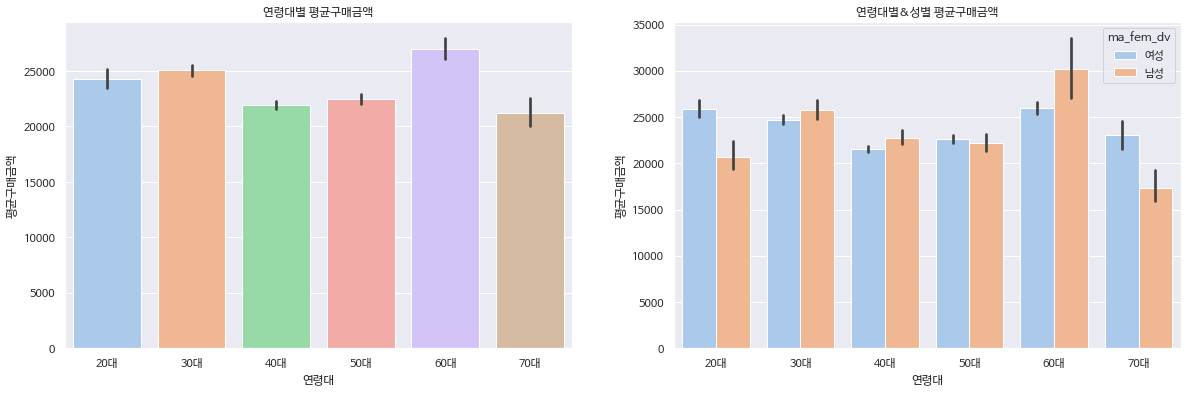

In [12]:
color = sns.color_palette('pastel')
fig, axes = plt.subplots(1,2,figsize=(20,6))
ax1= sns.barplot(x='ages',y= 'buy_am',data = pdde_final,order = sorted(pdde_final['ages'].unique()),ax=axes[0] )
ax1.set_title('연령대별 평균구매금액')
ax1.set(xlabel='연령대', ylabel='평균구매금액')

ax2=sns.barplot(x='ages',y= 'buy_am', data = pdde_final,order = sorted(pdde_final['ages'].unique()),hue = 'ma_fem_dv', ax=axes[1] )
ax2.set_title('연령대별&성별 평균구매금액')
ax2.set(xlabel='연령대', ylabel='평균구매금액')

# sns.barplot(data = pdde
#                 ,x='ages'
#                 ,y='buy_am'
                
#                 ,hue = 'ma_fem_dv'
#                 ,order = sorted(pdde['ages'].unique())
#                          )
plt.show()

- 위에 시각화 정보를 보면 알다시피 40대는 한번 소비할 때 많은 금액을 사용하지 않지만
20,30대(mz세대)는 한번 사용할 때 쓰는 금액이 비교적 크다.(명품과 연관이 있어보인다)

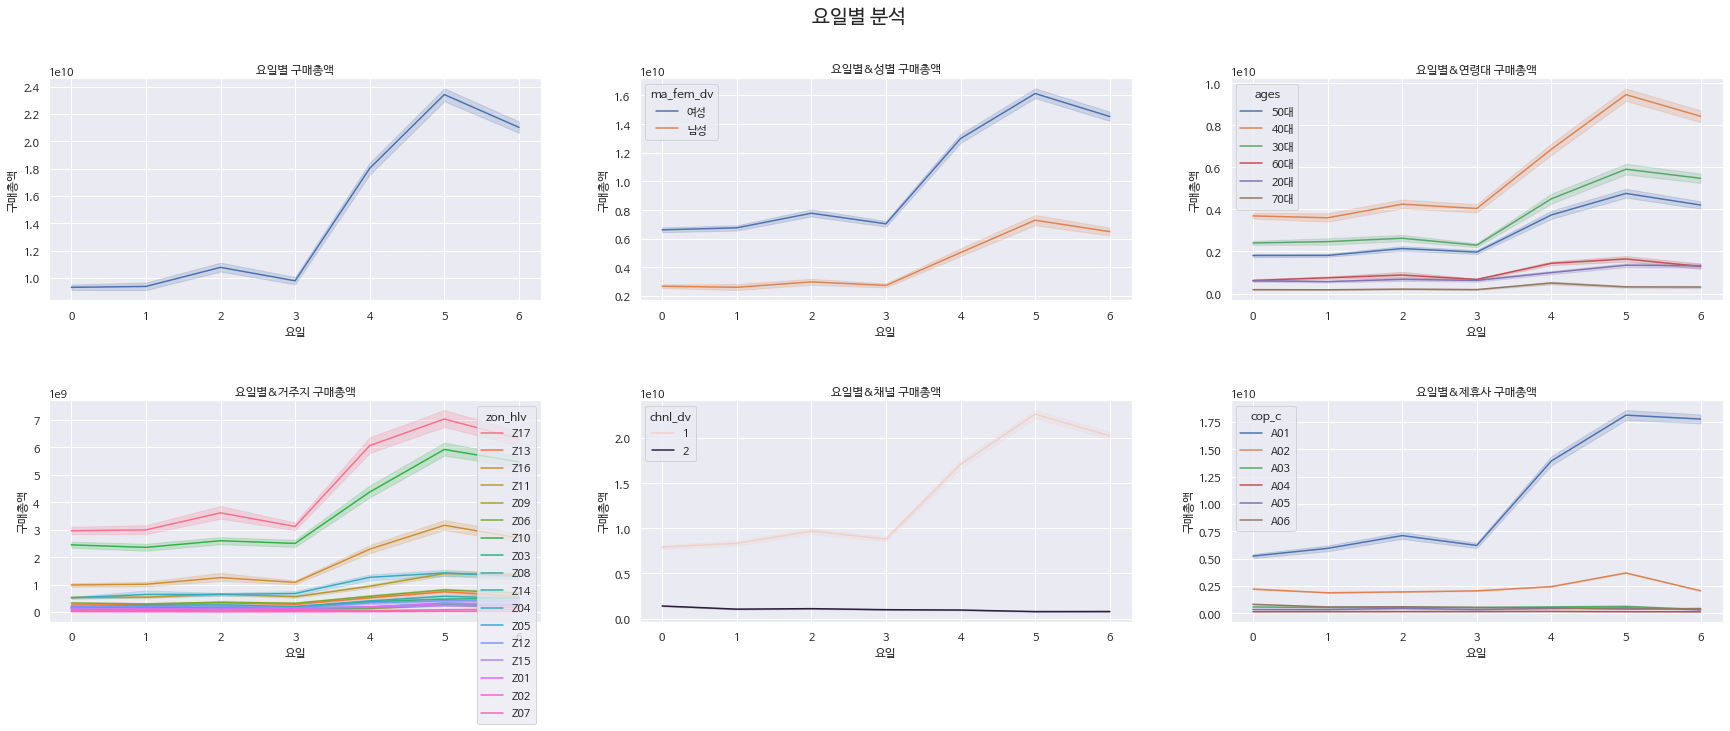

In [ ]:
# 요일별 데이터 분석


fig, axes = plt.subplots(2,3,figsize=(30,10))
# 전체 매출액





ax1 = sns.lineplot(data = pdde_final
                ,x='요일'
                ,y='buy_am'
                ,estimator=np.sum
                #,hue = 'ma_fem_dv'
                , ax = axes[0][0]
                          )
ax1.set_title('요일별 구매총액')
ax1.set(xlabel='요일', ylabel='구매총액')


# 성별별
ax2 = sns.lineplot(data = pdde_final
                ,x='요일'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'ma_fem_dv'
                , ax = axes[0][1]
                          )
ax2.set_title('요일별&성별 구매총액')
ax2.set(xlabel='요일', ylabel='구매총액')

# 연령대별
ax3 = sns.lineplot(data = pdde_final
                ,x='요일'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'ages'
                , ax = axes[0][2]
                          )
ax3.set_title('요일별&연령대 구매총액')
ax3.set(xlabel='요일', ylabel='구매총액')


# 거주지별
ax4 = sns.lineplot(data = pdde_final
                ,x='요일'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'zon_hlv'
                , ax = axes[1][0]
                          )
ax4.set_title('요일별&거주지 구매총액')
ax4.set(xlabel='요일', ylabel='구매총액')

# 채널별
ax5 = sns.lineplot(data = pdde_final
                ,x='요일'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'chnl_dv'
                , ax = axes[1][1]
                          )
ax5.set_title('요일별&채널 구매총액')
ax5.set(xlabel='요일', ylabel='구매총액')


# 제휴사별
ax6 = sns.lineplot(data = pdde_final
                ,x='요일'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'cop_c'
                , ax = axes[1][2]
                          )
ax6.set_title('요일별&제휴사 구매총액')
ax6.set(xlabel='요일', ylabel='구매총액')


plt.subplots_adjust(hspace=0.45)

plt.suptitle('요일별 분석', fontsize=20)
plt.show()

<pre>
{0:월, 1:화, 2:수, 3:목, 4:금, 5:토, 6:일}
1. 요일별 구매총액에서 금,토,일이 높은 매출을 보인다.(토요일이 제일 높다)


In [ ]:
pdde.groupby('clac_mcls_nm_x')['clac_mcls_nm_x'].count().sort_values(ascending=False)

clac_mcls_nm_x
스낵류       203697
식당        127320
국산과일      118735
요구르트      106619
잎채소       105662
           ...  
용기보증금          4
격투기            3
소모품            2
양곡선물세트         1
보험             1
Name: clac_mcls_nm_x, Length: 349, dtype: int64

## 상품대분류별 분석
- 구매빈도가 높은 상품
- 구매총액이 높은 상품

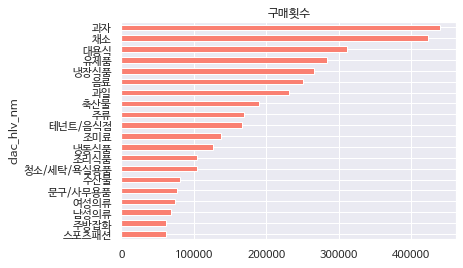

<Figure size 2160x720 with 0 Axes>

In [23]:
#구매횟수(대분류)

pdde_final.groupby('clac_hlv_nm')['clac_hlv_nm'].count().sort_values(ascending=True).tail(20).plot(kind='barh',color = ['salmon'], title = "구매횟수")
plt.figure(figsize = (30,10))
plt.show()

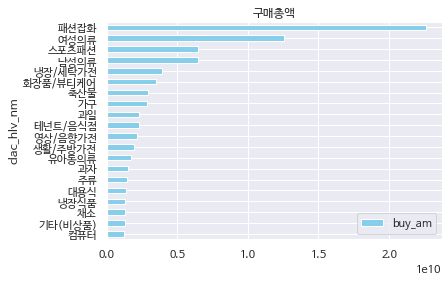

<Figure size 2160x720 with 0 Axes>

In [22]:
# 상품분류별 구매총액(대분류)

pdde_final.groupby('clac_hlv_nm')[['clac_hlv_nm', 'buy_am']].sum().sort_values(by='buy_am',ascending=True).tail(20).plot(kind='barh',color = ['skyblue'], title = "구매총액")
plt.figure(figsize = (30,10))
plt.show()

## 상품중분류별 분석
- 구매빈도가 높은 상품
- 구매총액이 높은 상품

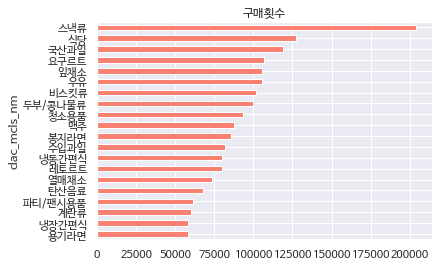

<Figure size 2160x720 with 0 Axes>

In [24]:
#구매횟수(중분류)
pdde_final.groupby('clac_mcls_nm')['clac_mcls_nm'].count().sort_values(ascending=True).tail(20).plot(kind='barh',color = ['salmon'], title = "구매횟수")
plt.figure(figsize = (30,10))
plt.show()

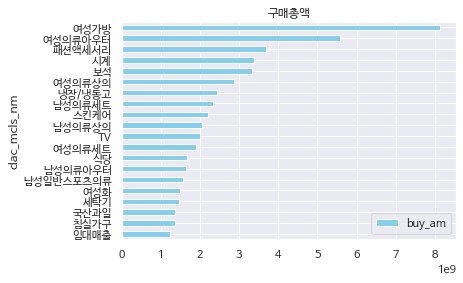

<Figure size 2160x720 with 0 Axes>

In [25]:
# 상품분류별 구매총액(중분류)
pdde_final.groupby('clac_mcls_nm')[['clac_mcls_nm', 'buy_am']].sum().sort_values(by='buy_am',ascending=True).tail(20).plot(kind='barh',color = ['skyblue'], title = "구매총액")
plt.figure(figsize = (30,10))
plt.show()

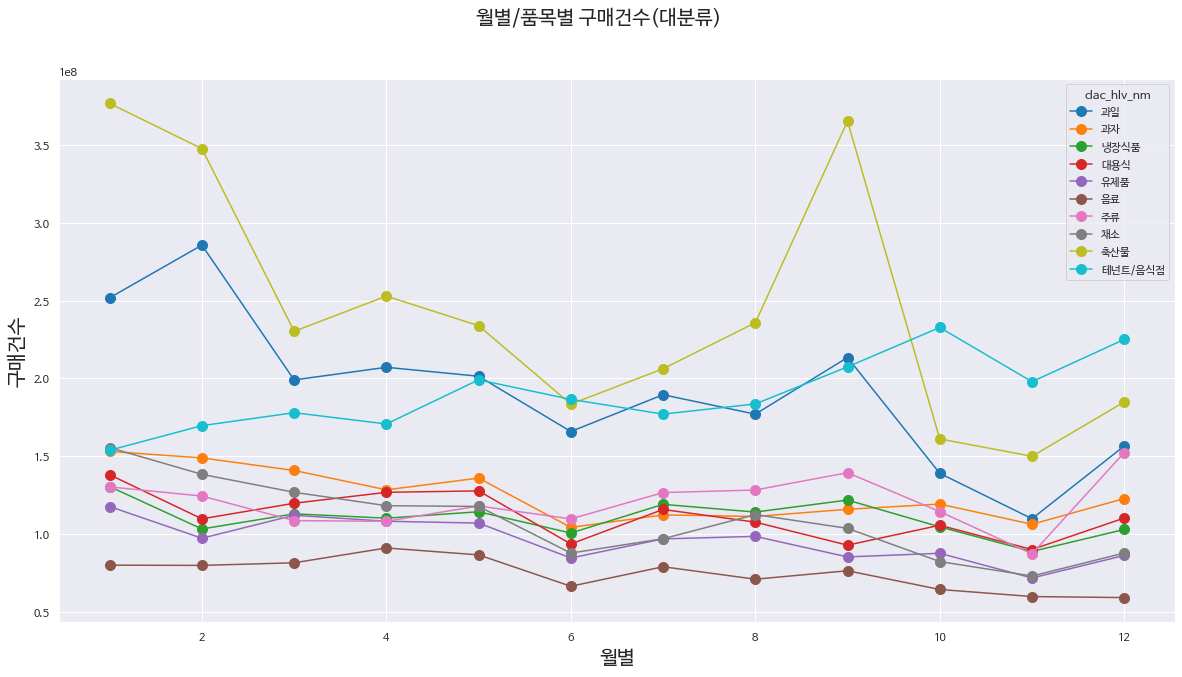

In [ ]:
sns.set_palette("tab10")

a = list(pdde_final.groupby(['clac_hlv_nm'])['buy_ct'].sum().sort_values(ascending=False).head(10).index)
idx=[]
for i in range(len(pdde_final)):
  if pdde_final['clac_hlv_nm'][i] in a:
    idx.append(i)

top_10_item = pdde_final.iloc[idx]

tmp = pd.pivot_table(top_10_item, index = 'month', columns='clac_hlv_nm', values='buy_ct', aggfunc='sum')
tmp.plot(marker = "o", markersize = 10, figsize = (20, 10))
plt.xlabel('월별', fontsize=20)
plt.ylabel('구매건수',fontsize=20)

plt.suptitle('월별/품목별 구매건수(대분류)', fontsize = 20)
plt.show()

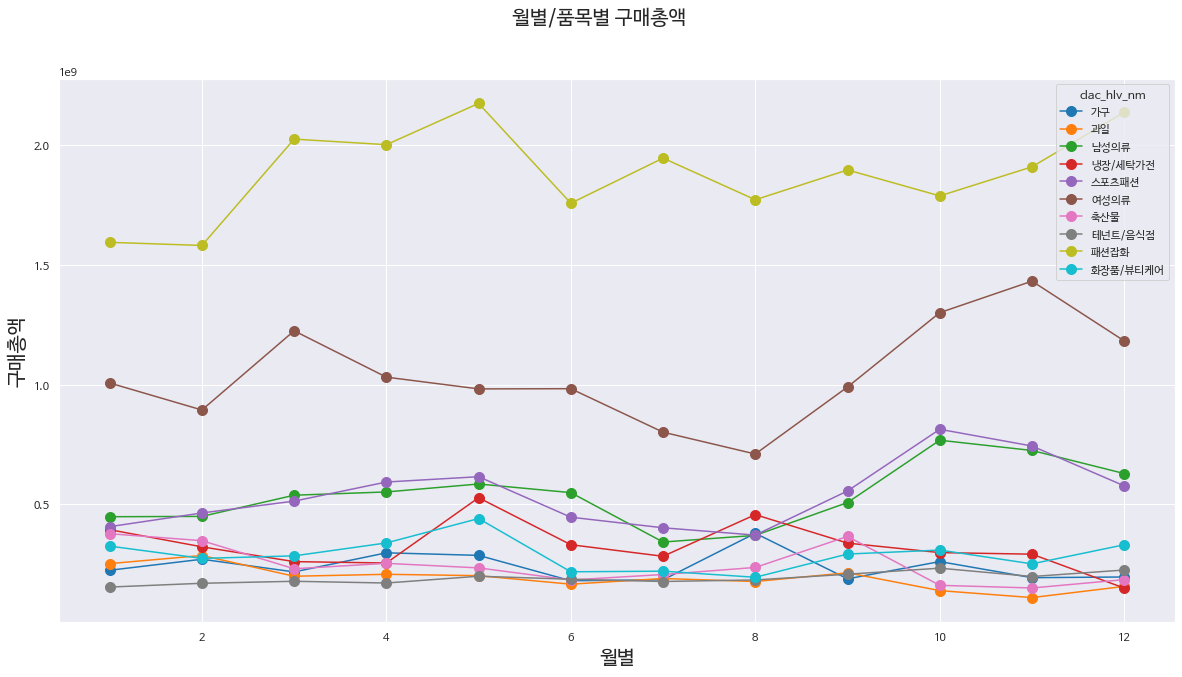

In [27]:
# 상위 구매금액 10개 품목
sns.set_palette("tab10")
a = list(pdde_final.groupby(['clac_hlv_nm'])['buy_am'].sum().sort_values(ascending=False).head(10).index)
idx=[]
for i in range(len(pdde_final)):
  if pdde_final['clac_hlv_nm'][i] in a:
    idx.append(i)

top_10_item = pdde_final.iloc[idx]

tmp = pd.pivot_table(top_10_item, index = 'month', columns='clac_hlv_nm', values='buy_am', aggfunc='sum')
tmp.plot(marker = "o", markersize = 10, figsize = (20, 10))
plt.xlabel('월별', fontsize=20)
plt.ylabel('구매총액',fontsize=20)

plt.suptitle('월별/품목별 구매총액', fontsize = 20)
plt.show()

## 상위 품목 중분류 확인

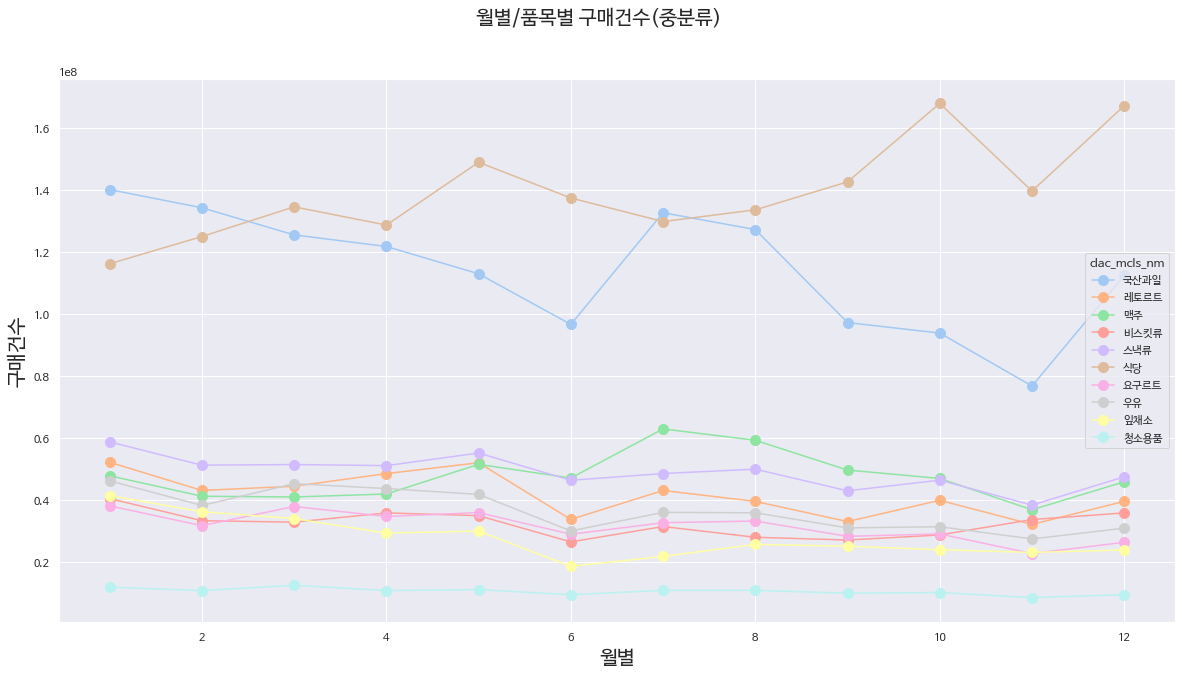

In [ ]:
# 상위 구매건수 10개 품목
a = list(pdde_final.groupby(['clac_mcls_nm'])['buy_ct'].sum().sort_values(ascending=False).head(10).index)
idx=[]
for i in range(len(pdde_final)):
  if pdde_final['clac_mcls_nm'][i] in a:
    idx.append(i)

top_10_item = pdde_final.iloc[idx]

tmp = pd.pivot_table(top_10_item, index = 'month', columns='clac_mcls_nm', values='buy_am', aggfunc='sum')
tmp.plot(marker = "o", markersize = 10, figsize = (20, 10))
plt.xlabel('월별', fontsize=20)
plt.ylabel('구매건수',fontsize=20)

plt.suptitle('월별/품목별 구매건수(중분류)', fontsize = 20)
plt.show()

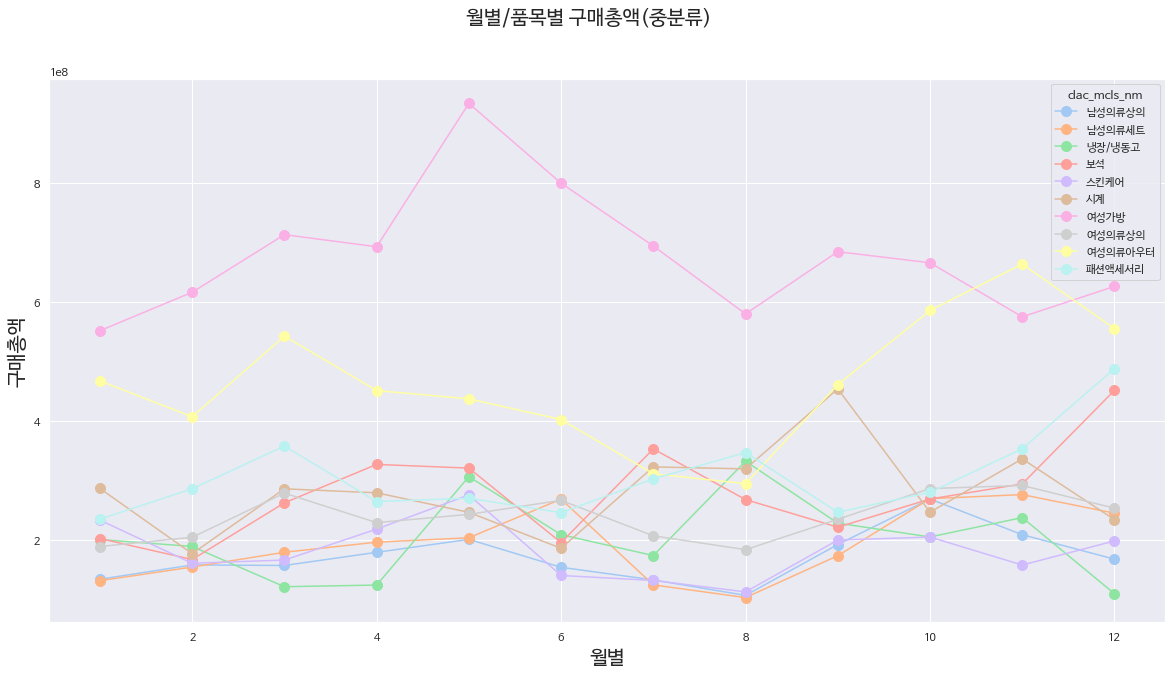

In [ ]:
# 상위 구매금액 10개 품목
a = list(pdde_final.groupby(['clac_mcls_nm'])['buy_am'].sum().sort_values(ascending=False).head(10).index)
idx=[]
for i in range(len(pdde_final)):
  if pdde_final['clac_mcls_nm'][i] in a:
    idx.append(i)

top_10_item = pdde_final.iloc[idx]

tmp = pd.pivot_table(top_10_item, index = 'month', columns='clac_mcls_nm', values='buy_am', aggfunc='sum')
tmp.plot(marker = "o", markersize = 10, figsize = (20, 10))
plt.xlabel('월별', fontsize=20)
plt.ylabel('구매총액',fontsize=20)

plt.suptitle('월별/품목별 구매총액(중분류)', fontsize = 20)
plt.show()

In [ ]:
a = list(pdde.groupby(['clac_hlv_nm_x'])['buy_am'].sum().sort_values(ascending=False).head(10).index)
a

['패션잡화',
 '여성의류',
 '스포츠패션',
 '남성의류',
 '냉장/세탁가전',
 '화장품/뷰티케어',
 '축산물',
 '가구',
 '과일',
 '테넌트/음식점']

In [ ]:
#pdde[pdde['clac_hlv_nm_x']=='여성가방']
pdde['clac_hlv_nm_x'].unique()

array(['남성의류', '주방잡화', '테넌트/음식점', '속옷/양말/홈웨어', '구기/필드스포츠', '여성의류', '음료',
       '아웃도어/레저', '유아동의류', '패션잡화', '스포츠패션', '식기/조리기구', '과자', '조리식품',
       '침구/수예', '대용식', '헬스/피트니스', '서적/음반/악기', '생활/렌탈서비스', '조미료', '주류',
       '수산물', '완구', '채소', '유아식품', '시즌스포츠', '과일', '상품권', '냉장식품', '냉동식품',
       '축산물', '자동차용품', '화장품/뷰티케어', '커피/차', '계절가전', '가구', '건강식품',
       '영상/음향가전', '양곡', '유제품', '생활/주방가전', '냉장/세탁가전', '여행/레저서비스', '세제/위생',
       '퍼스널케어', '컴퓨터', '문구/사무용품', '모바일', '원예/애완', '병통조림', '건강용품',
       '출산/육아용품', '공구/안전용품', '건해산물', '인테리어/조명', '청소/세탁/욕실용품', '기타(비상품)',
       '담배', '기타상품', '금융/보험서비스'], dtype=object)

In [ ]:
pdde_final.columns

Index(['cust', 'ma_fem_dv', 'ages', 'zon_hlv', 'rct_no', 'chnl_dv', 'cop_c',
       'br_c', 'pd_c', 'de_dt', 'de_hr', 'buy_am', 'buy_ct', 'pd_nm',
       'clac_hlv_nm', 'clac_mcls_nm', 'zon_mcls', '날짜', '강수량(mm)', '평균기온(℃)',
       '최저기온(℃)', '최고기온(℃)', '평균습도(%rh)', '최저습도(%rh)', '일조합(hr)', '일사합(MJ/m2)',
       'year', 'month', '요일', '일교차', '불쾌지수', 'holiday_anniversary'],
      dtype='object')

## 기념일 & 공휴일에 따른 시각화

[Text(0, 0.5, '평균 구매 금액'), Text(0.5, 0, '공휴일&기념일 여부')]

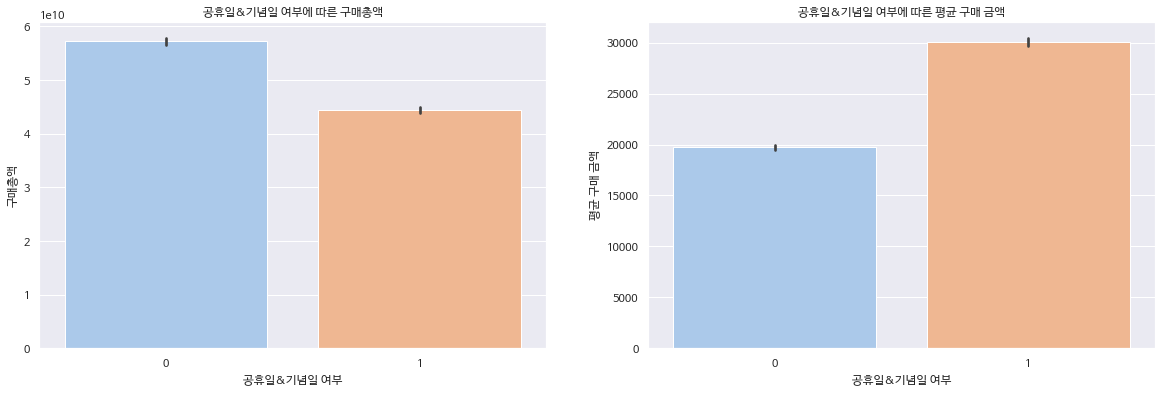

In [ ]:
sns.set_palette('pastel')
fig, axes = plt.subplots(1,2,figsize=(20,6))

ax1 = sns.barplot(data = pdde_final
                ,x='holiday_anniversary'
                ,y='buy_am'
                ,estimator=np.sum
                ,ax = axes[0]
)
ax1.set_title('공휴일&기념일 여부에 따른 구매총액')
ax1.set(xlabel='공휴일&기념일 여부', ylabel='구매총액')

ax2 = sns.barplot(data = pdde_final
                ,x='holiday_anniversary'
                ,y='buy_am'
                
                ,ax = axes[1]
)
ax2.set_title('공휴일&기념일 여부에 따른 평균 구매 금액')
ax2.set(xlabel='공휴일&기념일 여부', ylabel='평균 구매 금액')

- 공휴일&기념일로 분류한게 125일인데 예상외로 공휴일& 기념일이 아닌 날에 총 소비금액이 더 높았다.
- 평균소비금액은 공휴일&기념일이 더 높다

[Text(0, 0.5, '소비금액(평균)'), Text(0.5, 0, '월')]

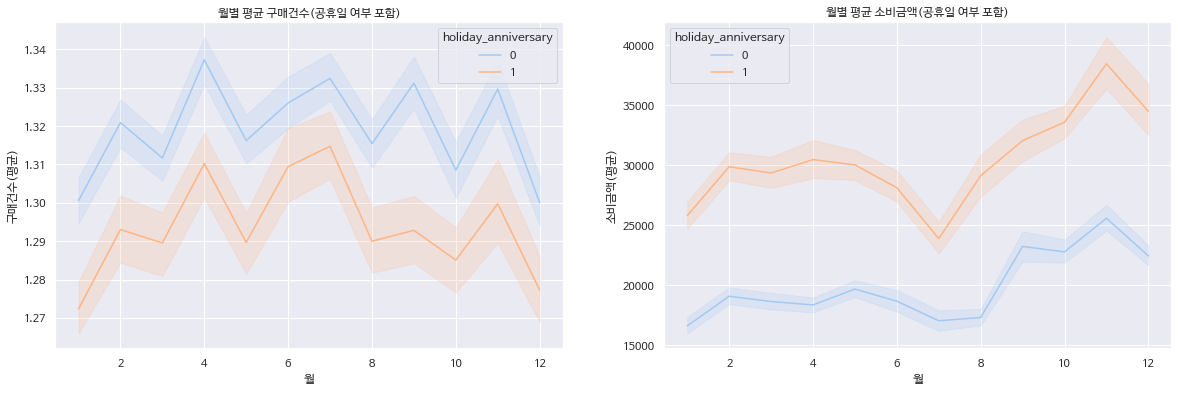

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(20,6))

ax1 = sns.lineplot(data = pdde_final
                ,x='month'
                ,y='buy_ct'
                #,estimator=np.sum
                ,hue = 'holiday_anniversary'
                , ax = axes[0]
                          )
ax1.set_title('월별 평균 구매건수(공휴일 여부 포함)')
ax1.set(xlabel='월', ylabel='구매건수(평균)')


ax2 = sns.lineplot(data = pdde_final
                ,x='month'
                ,y='buy_am'
                #,estimator=np.sum
                ,hue = 'holiday_anniversary'
                , ax = axes[1]
                          )
ax2.set_title('월별 평균 소비금액(공휴일 여부 포함)')
ax2.set(xlabel='월', ylabel='소비금액(평균)')

- 의외로 평균 구매 건수는 기념일&공휴일이 아닐때가 더 높았다.
- 하지만 평균 소비 금액을 보았을 때, 기념일&공휴일인 날이 더 높았다.
- 월별 평균 소비금액은 7월달에 가장 낮았고 11월달에 가장 높다.


# 오프라인 상품구매정보 시각화

In [28]:
# 오프라인 상품 구매정보만 뽑아내서 새로운 데이터프레임 생성 (4381743건 -> 3953242 )
pdde_offline = pdde_final[pdde_final['chnl_dv']==1].reset_index(drop=True)
pdde_offline.shape

(3953242, 32)

## 오프라인 상품 구매 고객 파악

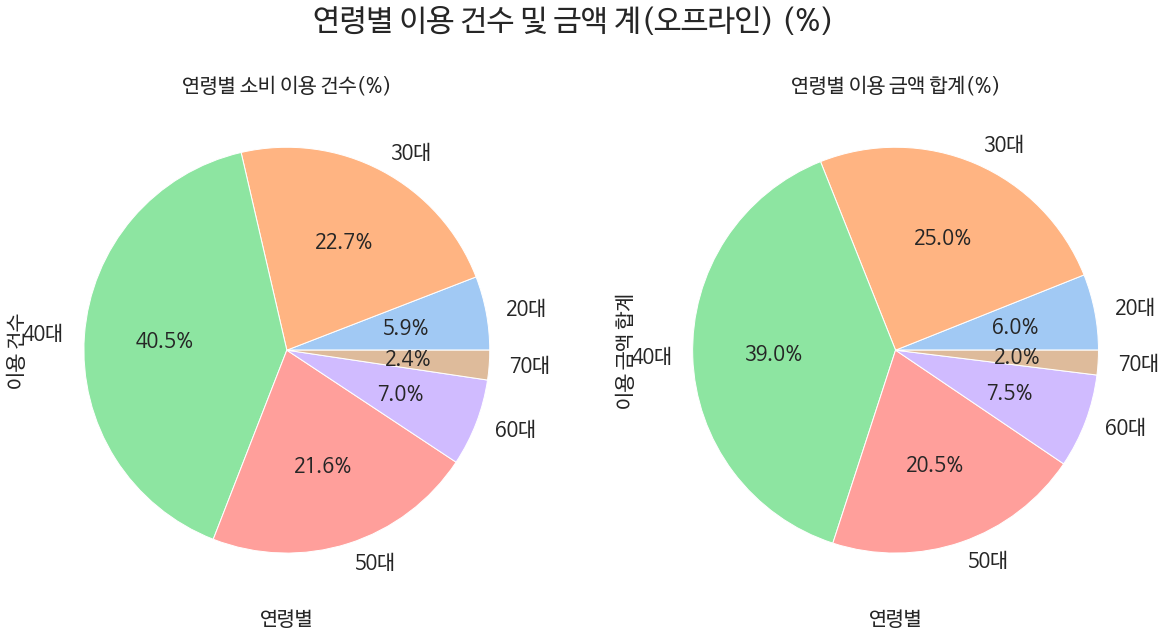

In [33]:
color = sns.color_palette('pastel')[:10]
a = pdde_offline.groupby("ages")["buy_ct"].sum()
b= pdde_offline.groupby("ages")["buy_am"].sum()

plt.figure(figsize = (20, 10))

plt.subplot(1,2,1)
plt.title("연령별 소비 이용 건수(%)", fontsize=20)

a.plot(kind = 'pie', autopct='%1.1f%%',textprops= {'fontsize' : 20}, colors = color)
plt.xlabel('연령별', fontsize=20)
plt.ylabel('이용 건수',fontsize=20)

plt.subplot(1,2,2)
plt.title("연령별 이용 금액 합계(%)", fontsize=20)

b.plot(kind = 'pie', autopct='%1.1f%%',textprops= {'fontsize' : 20}, colors = color)
plt.xlabel('연령별', fontsize=20)
plt.ylabel('이용 금액 합계', fontsize=20)

plt.suptitle('연령별 이용 건수 및 금액 계(오프라인) (%)', fontsize = 30)
plt.show()

## 오프라인 상품 계절성 파악

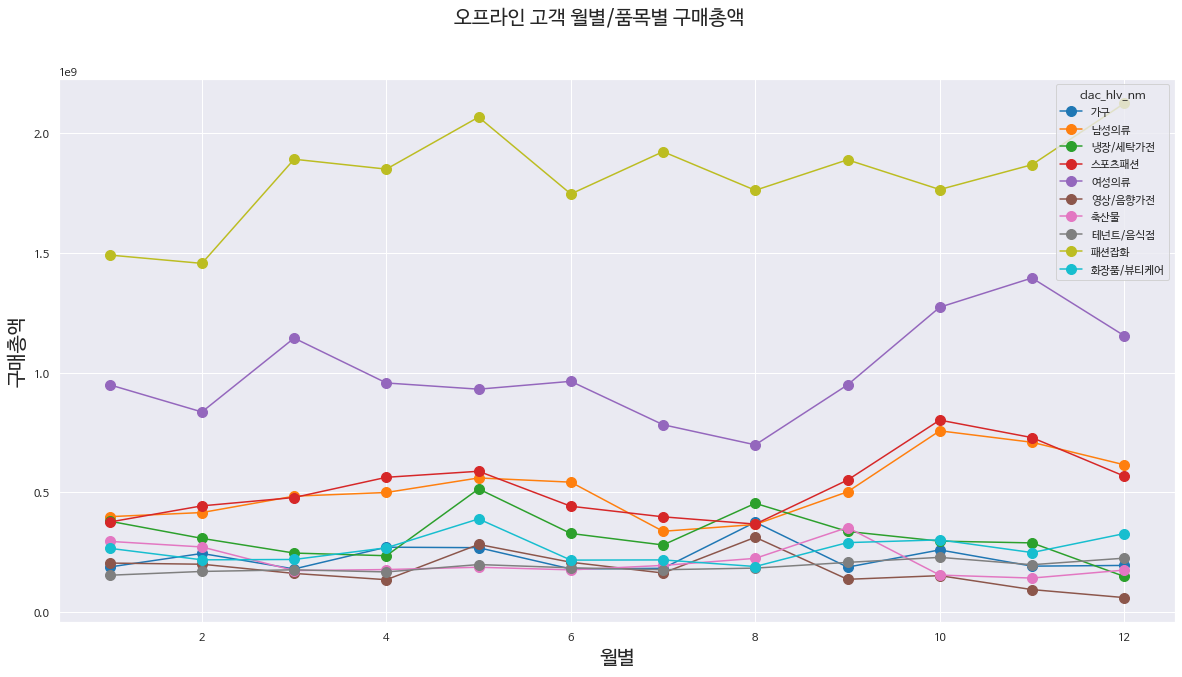

In [32]:
# 상위 구매금액 10개 품목
sns.set_palette("tab10")
a = list(pdde_offline.groupby(['clac_hlv_nm'])['buy_am'].sum().sort_values(ascending=False).head(10).index)
idx=[]
for i in range(len(pdde_offline)):
  if pdde_offline['clac_hlv_nm'][i] in a:
    idx.append(i)

top_10_item = pdde_offline.iloc[idx]

tmp = pd.pivot_table(top_10_item, index = 'month', columns='clac_hlv_nm', values='buy_am', aggfunc='sum')
tmp.plot(marker = "o", markersize = 10, figsize = (20, 10))
plt.xlabel('월별', fontsize=20)
plt.ylabel('구매총액',fontsize=20)

plt.suptitle('오프라인 고객 월별/품목별 구매총액', fontsize = 20)
plt.show()

## 오프라인 상품 평균 가격 분석
- 고객 구매력에 따라 상품군 추천을 위해 상품 평균가 파악

Text(0.5, 1.0, '상품대분류 평균가 top10')

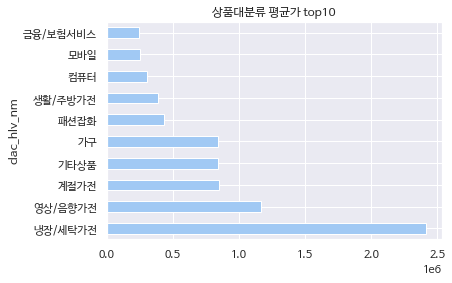

In [43]:
# 상품 대분류 평균가 top10
sns.set_palette('pastel')
pdde_offline.groupby('clac_hlv_nm')['buy_am'].mean().sort_values(ascending=False).head(10).plot(kind = 'barh')
plt.title('상품대분류 평균가 top10')

Text(0.5, 1.0, '상품중분류 평균가 top10')

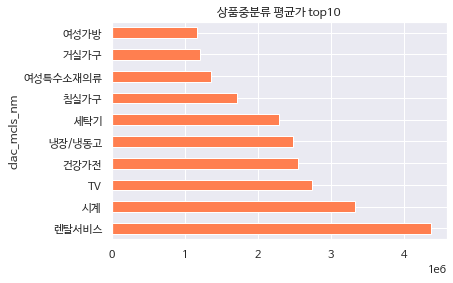

In [44]:
sns.set_palette('pastel')
pdde_offline.groupby('clac_mcls_nm')['buy_am'].mean().sort_values(ascending=False).head(10).plot(kind = 'barh',color = 'coral')
plt.title('상품중분류 평균가 top10')

## 공휴일 & 기념일 여부에 따른 평균소비금액 비교

[Text(0, 0.5, '평균 구매 금액'), Text(0.5, 0, '공휴일&기념일 여부')]

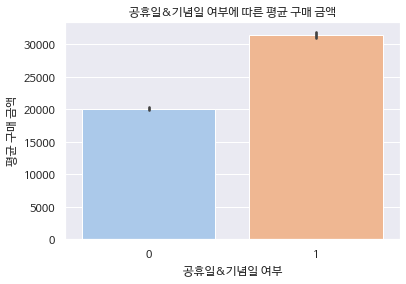

In [46]:
ax2 = sns.barplot(data = pdde_offline
                ,x='holiday_anniversary'
                ,y='buy_am'
                
                
)
ax2.set_title('공휴일&기념일 여부에 따른 평균 구매 금액')
ax2.set(xlabel='공휴일&기념일 여부', ylabel='평균 구매 금액')

# 제휴사 시각화

In [ ]:
cop_final.columns

Index(['cust', 'rct_no', 'cop_c', 'br_c', 'chnl_dv', 'de_dt', 'vst_dt',
       'de_hr', 'buy_am', 'ma_fem_dv', 'ages', 'zon_hlv', 'zon_mcls', '날짜',
       '강수량(mm)', '평균기온(℃)', '최저기온(℃)', '최고기온(℃)', '평균습도(%rh)', '최저습도(%rh)',
       '일조합(hr)', '일사합(MJ/m2)', 'year', 'month', '요일', '일교차', '불쾌지수',
       'holiday_anniversary'],
      dtype='object')

## 고객 기준별 제휴사 이용건수 확인
- 연령대별 고객수 확인
- 성별별 고객수 확인
- 거주지별 고객수 확인

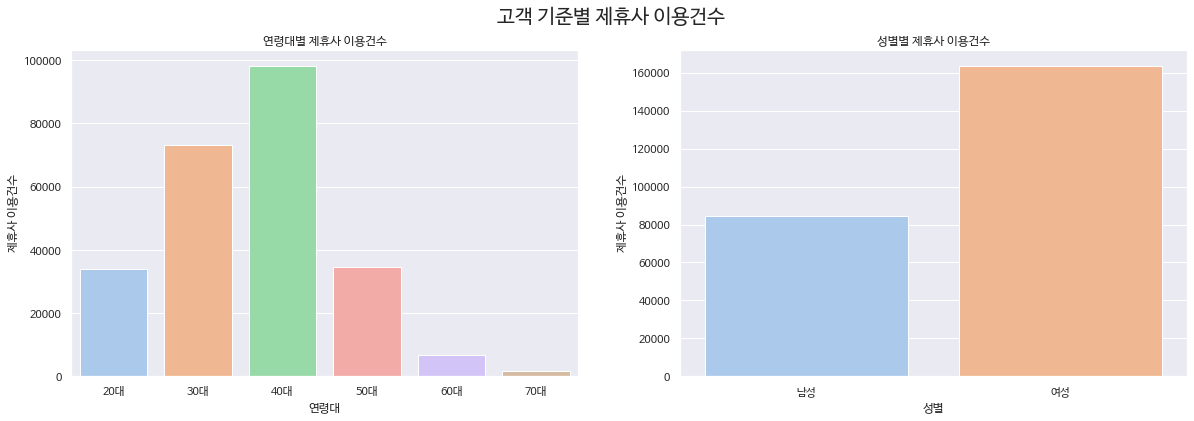

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(20,6))
sns.set_palette('pastel')
ax1= sns.countplot(x='ages',data = cop_final,order = sorted(cop_final['ages'].unique()), ax=axes[0] )
ax1.set_title('연령대별 제휴사 이용건수')
ax1.set(xlabel='연령대', ylabel='제휴사 이용건수')

ax2=sns.countplot(x='ma_fem_dv',data = cop_final, ax=axes[1] )
ax2.set_title('성별별 제휴사 이용건수')
ax2.set(xlabel='성별', ylabel='제휴사 이용건수')



plt.suptitle('고객 기준별 제휴사 이용건수', fontsize=20)
plt.show()

## 제휴사별, 점포별 이용건수
- 제휴사별 이용건수
- 점포별 이용건수

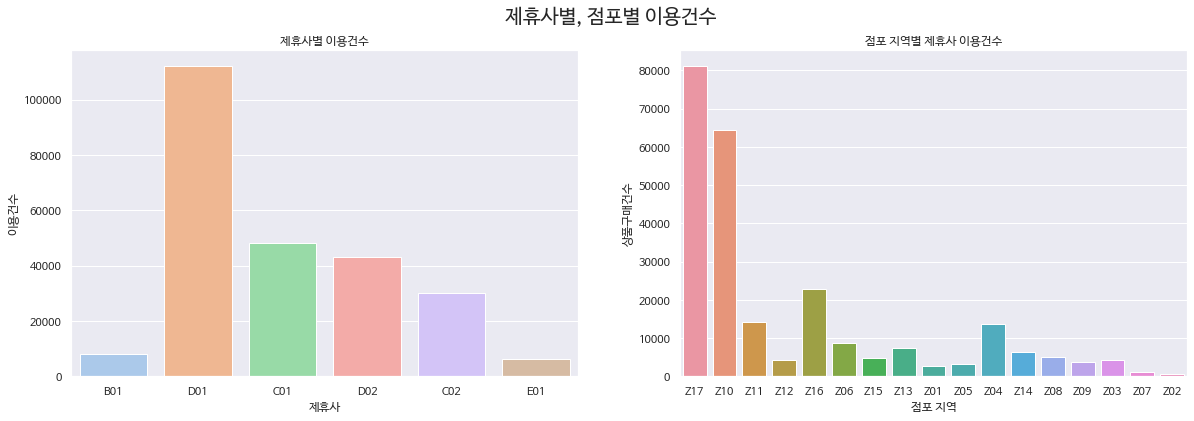

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(20,6))
sns.set_palette('pastel')
ax1= sns.countplot(x='cop_c',data = cop_final,ax=axes[0] )
ax1.set_title('제휴사별 이용건수')
ax1.set(xlabel='제휴사', ylabel='이용건수')

ax2=sns.countplot(x='zon_hlv',data = cop_final, ax=axes[1] )
ax2.set_title('점포 지역별 제휴사 이용건수')
ax2.set(xlabel='점포 지역', ylabel='상품구매건수')

plt.suptitle('제휴사별, 점포별 이용건수', fontsize=20)
plt.show()

- D01: F&B
- C01: 엔터테인먼트
- D02: F&B
- C02: 엔터테인먼트
- B01: 숙박업종
- E01: 렌탈업종


## 이용일자별 확인
- 연도는 2021년으로 고정돼있다.
- 월별 분석
- 요일별 분석(0이 월요일, 6이 일요일)

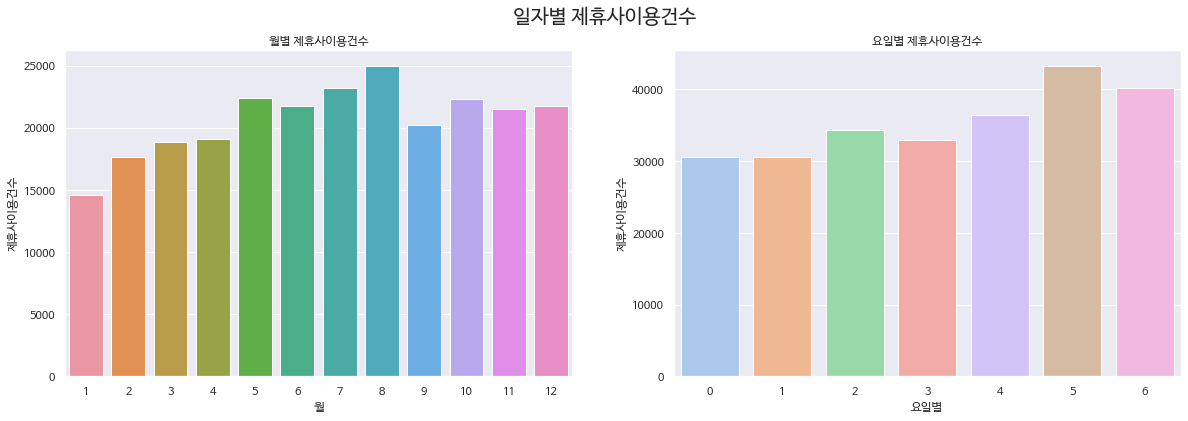

In [ ]:
# 일자별 제휴사이용건수 확인
fig, axes = plt.subplots(1,2,figsize=(20,6))


ax2=sns.countplot(x='month',data = cop_final,order = sorted(cop_final['month'].unique()), ax=axes[0] )
ax2.set_title('월별 제휴사이용건수')
ax2.set(xlabel='월', ylabel='제휴사이용건수')

ax3=sns.countplot(x='요일',data = cop_final,order = sorted(cop_final['요일'].unique()), ax=axes[1] )
ax3.set_title('요일별 제휴사이용건수')
ax3.set(xlabel='요일별', ylabel='제휴사이용건수')

plt.suptitle('일자별 제휴사이용건수', fontsize=20)
plt.show()

### 월별 분석
- 이용금액
- 이용시간

- 7월, 8월에(휴가철?)에 제휴사 이용건수가 높게 나타났다.
- 주말에 제휴사 이용건수가 높게 나타났다.

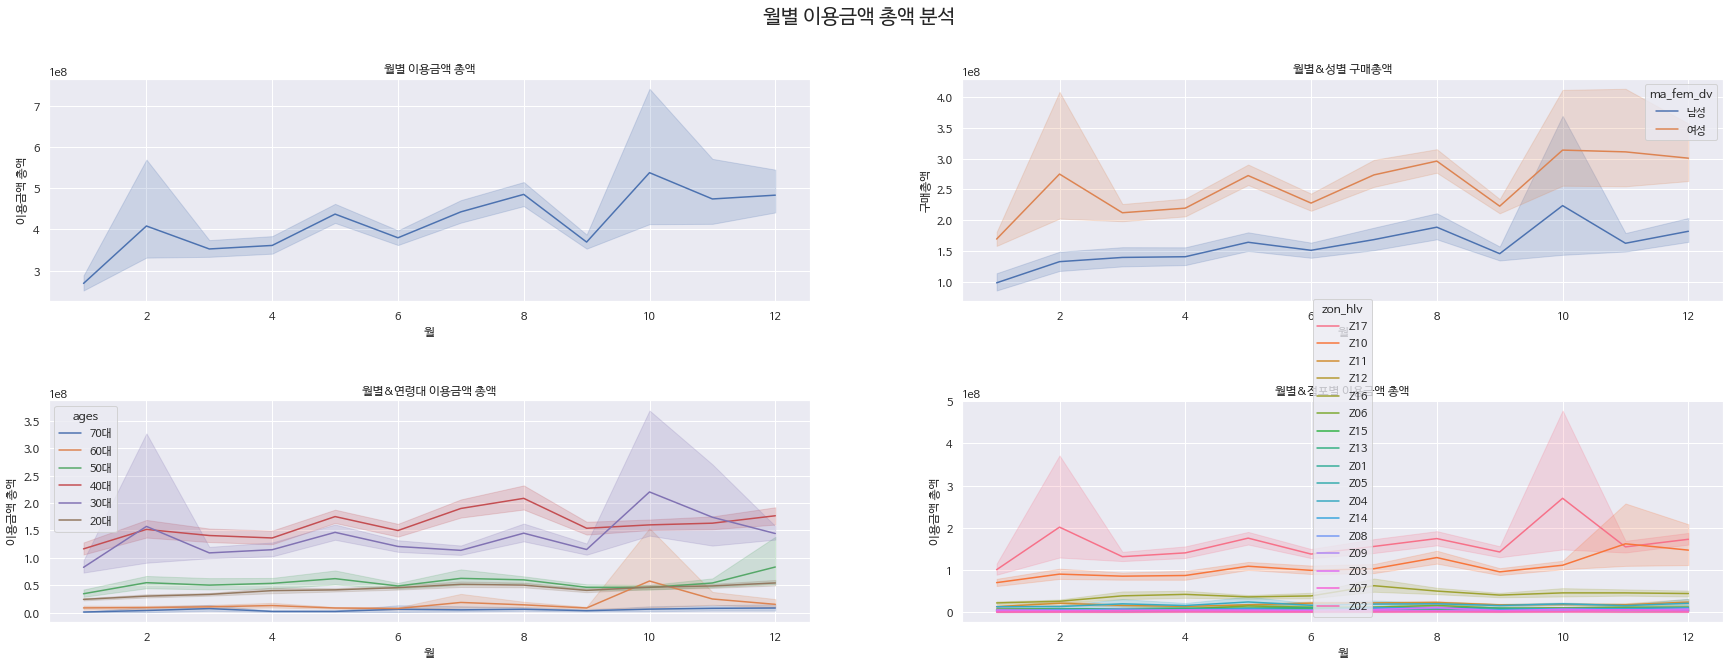

In [ ]:
# 월별 데이터 분석


fig, axes = plt.subplots(2,2,figsize=(30,10))
# 전체 매출액





ax1 = sns.lineplot(data = cop_final
                ,x='month'
                ,y='buy_am'
                ,estimator=np.sum
                #,hue = 'ma_fem_dv'
                , ax = axes[0][0]
                          )
ax1.set_title('월별 이용금액 총액')
ax1.set(xlabel='월', ylabel='이용금액 총액')


# 성별별
ax2 = sns.lineplot(data = cop_final
                ,x='month'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'ma_fem_dv'
                , ax = axes[0][1]
                          )
ax2.set_title('월별&성별 구매총액')
ax2.set(xlabel='월', ylabel='구매총액')

# 연령대별
ax3 = sns.lineplot(data = cop_final
                ,x='month'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'ages'
                , ax = axes[1][0]
                          )
ax3.set_title('월별&연령대 이용금액 총액')
ax3.set(xlabel='월', ylabel='이용금액 총액')


# 점포별
ax4 = sns.lineplot(data = cop_final
                ,x='month'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'zon_hlv'
                , ax = axes[1][1]
                          )
ax4.set_title('월별&점포별 이용금액 총액')
ax4.set(xlabel='월', ylabel='이용금액 총액')



plt.subplots_adjust(hspace=0.45)

plt.suptitle('월별 이용금액 총액 분석', fontsize=20)
plt.show()

[Text(0, 0.5, '이용금액 총액'), Text(0.5, 0, '월')]

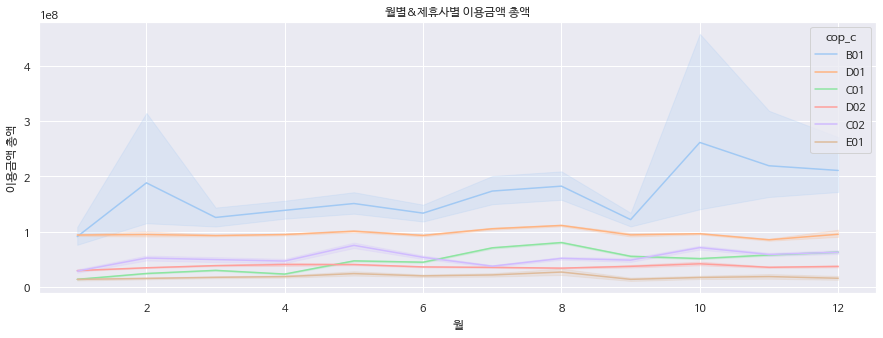

In [ ]:
plt.figure(figsize=(15,5))
ax1 = sns.lineplot(data = cop_final
                ,x='month'
                ,y='buy_am'
                ,hue = 'cop_c'
                ,estimator=np.sum
                
                          )
ax1.set_title('월별&제휴사별 이용금액 총액')
ax1.set(xlabel='월', ylabel='이용금액 총액')


- 숙박업종에 이용금액 총액이 가장 높다.
- B01: 숙박업종
- D01: F&B
- C01: 엔터테인먼트
- D02: F&B
- C02: 엔터테인먼트
- E01: 렌탈업종


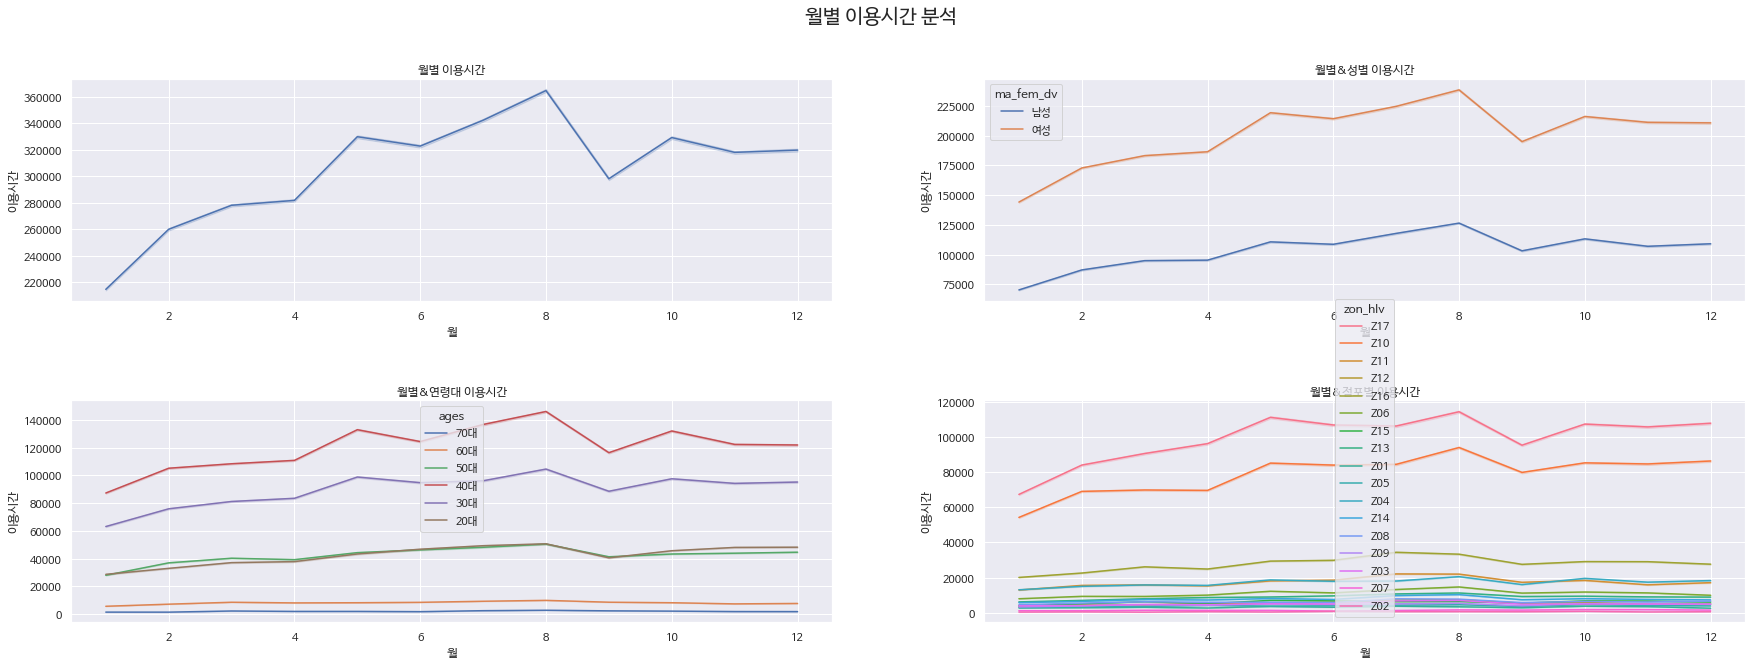

In [ ]:
# 월별 이용시간 분석


fig, axes = plt.subplots(2,2,figsize=(30,10))
# 전체 이용시간





ax1 = sns.lineplot(data = cop_final
                ,x='month'
                ,y='de_hr'
                ,estimator=np.sum
                #,hue = 'ma_fem_dv'
                , ax = axes[0][0]
                          )
ax1.set_title('월별 이용시간')
ax1.set(xlabel='월', ylabel='이용시간')


# 성별별
ax2 = sns.lineplot(data = cop_final
                ,x='month'
                ,y='de_hr'
                ,estimator=np.sum
                ,hue = 'ma_fem_dv'
                , ax = axes[0][1]
                          )
ax2.set_title('월별&성별 이용시간')
ax2.set(xlabel='월', ylabel='이용시간')

# 연령대별
ax3 = sns.lineplot(data = cop_final
                ,x='month'
                ,y='de_hr'
                ,estimator=np.sum
                ,hue = 'ages'
                , ax = axes[1][0]
                          )
ax3.set_title('월별&연령대 이용시간')
ax3.set(xlabel='월', ylabel='이용시간')


# 점포별
ax4 = sns.lineplot(data = cop_final
                ,x='month'
                ,y='de_hr'
                ,estimator=np.sum
                ,hue = 'zon_hlv'
                , ax = axes[1][1]
                          )
ax4.set_title('월별&점포별 이용시간')
ax4.set(xlabel='월', ylabel='이용시간')



plt.subplots_adjust(hspace=0.45)

plt.suptitle('월별 이용시간 분석', fontsize=20)
plt.show()

- 8월에 가장 높은 이용시간(휴가철)
- 9월에 갑자기 이용시간이 낮아진다.

[Text(0, 0.5, '이용시간'), Text(0.5, 0, '월')]

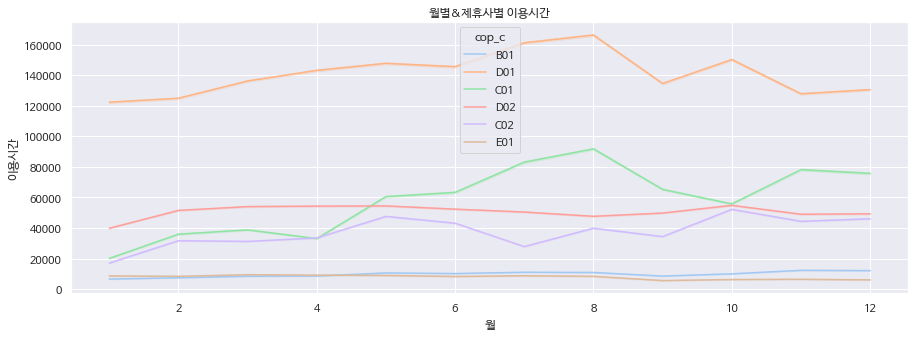

In [ ]:
plt.figure(figsize=(15,5))
ax1 = sns.lineplot(data = cop_final
                ,x='month'
                ,y='de_hr'
                ,hue = 'cop_c'
                ,estimator=np.sum
                
                          )
ax1.set_title('월별&제휴사별 이용시간')
ax1.set(xlabel='월', ylabel='이용시간')


- F&B 제휴사에 가장 오랜시간을 사용한다.
- B01: 숙박업종
- D01: F&B
- C01: 엔터테인먼트
- D02: F&B
- C02: 엔터테인먼트
- E01: 렌탈업종


In [ ]:
cop_final.columns

Index(['cust', 'rct_no', 'cop_c', 'br_c', 'chnl_dv', 'de_dt', 'vst_dt',
       'de_hr', 'buy_am', 'ma_fem_dv', 'ages', 'zon_hlv', 'zon_mcls', '날짜',
       '강수량(mm)', '평균기온(℃)', '최저기온(℃)', '최고기온(℃)', '평균습도(%rh)', '최저습도(%rh)',
       '일조합(hr)', '일사합(MJ/m2)', 'year', 'month', '요일', '일교차', '불쾌지수',
       'holiday_anniversary'],
      dtype='object')

### 요일별 분석
- 이용금액
- 이용시간

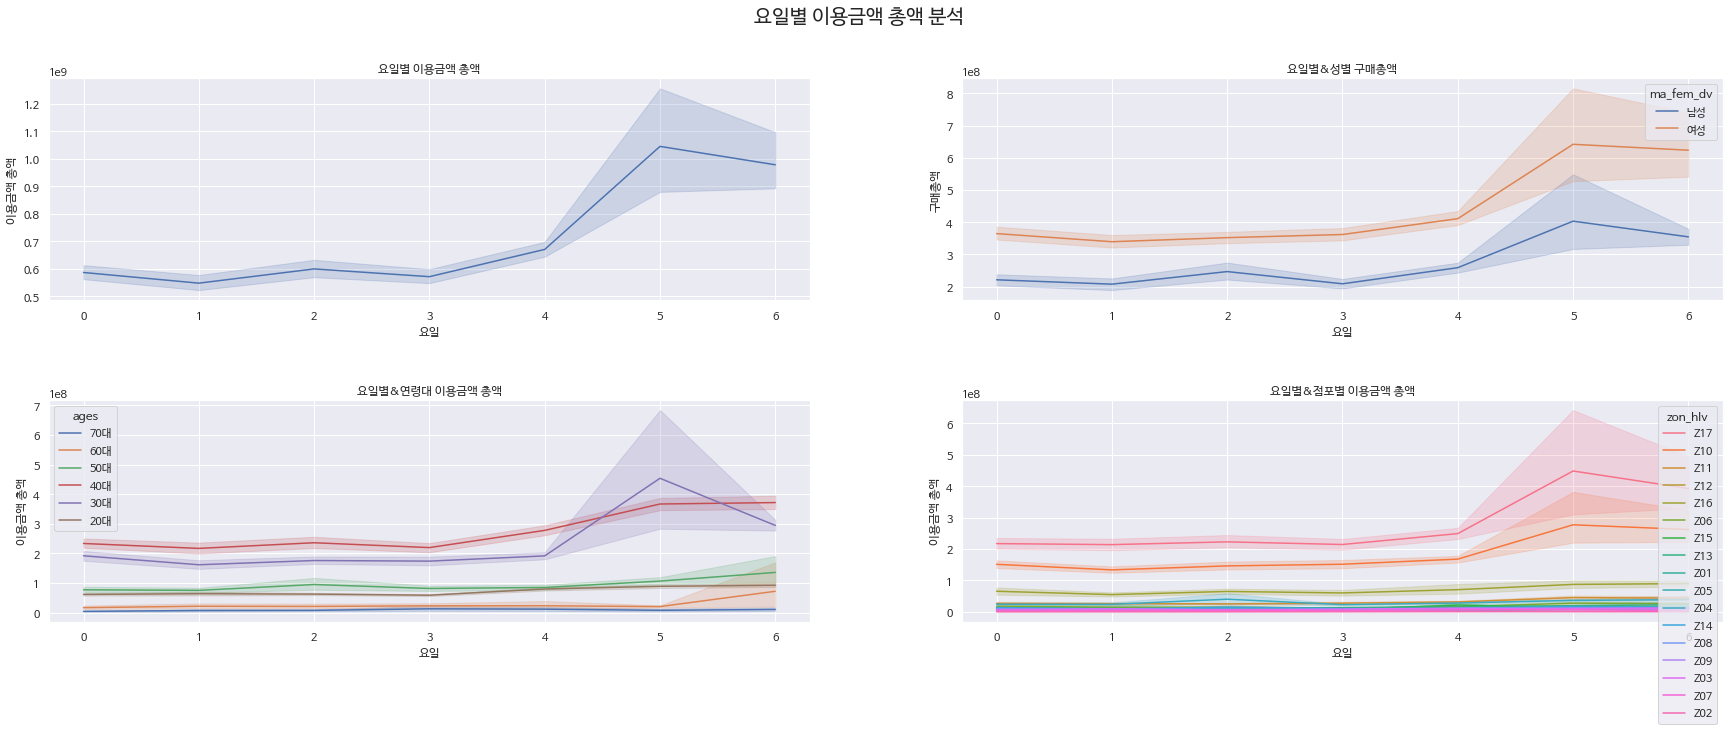

In [ ]:
# 요일별 데이터 분석


fig, axes = plt.subplots(2,2,figsize=(30,10))
# 전체 매출액





ax1 = sns.lineplot(data = cop_final
                ,x='요일'
                ,y='buy_am'
                ,estimator=np.sum
                #,hue = 'ma_fem_dv'
                , ax = axes[0][0]
                          )
ax1.set_title('요일별 이용금액 총액')
ax1.set(xlabel='요일', ylabel='이용금액 총액')


# 성별별
ax2 = sns.lineplot(data = cop_final
                ,x='요일'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'ma_fem_dv'
                , ax = axes[0][1]
                          )
ax2.set_title('요일별&성별 구매총액')
ax2.set(xlabel='요일', ylabel='구매총액')

# 연령대별
ax3 = sns.lineplot(data = cop_final
                ,x='요일'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'ages'
                , ax = axes[1][0]
                          )
ax3.set_title('요일별&연령대 이용금액 총액')
ax3.set(xlabel='요일', ylabel='이용금액 총액')


# 점포별
ax4 = sns.lineplot(data = cop_final
                ,x='요일'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'zon_hlv'
                , ax = axes[1][1]
                          )
ax4.set_title('요일별&점포별 이용금액 총액')
ax4.set(xlabel='요일', ylabel='이용금액 총액')



plt.subplots_adjust(hspace=0.45)

plt.suptitle('요일별 이용금액 총액 분석', fontsize=20)
plt.show()

<pre>
*** 30대가 토요일에 40대보다 더 많은 이용금액을 사용한다.


[Text(0, 0.5, '이용금액 총액'), Text(0.5, 0, '요일')]

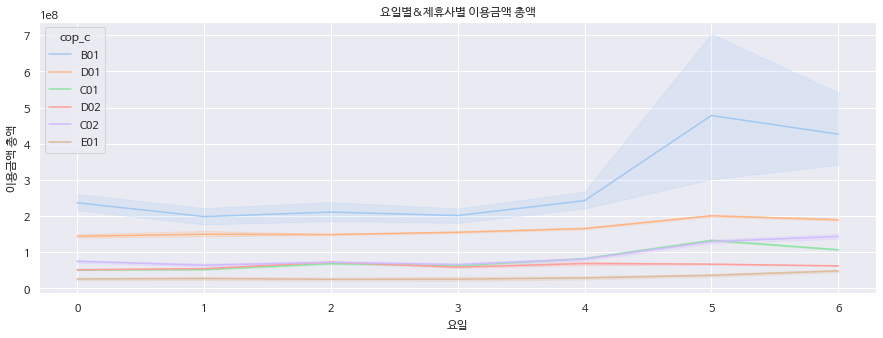

In [ ]:
plt.figure(figsize=(15,5))
ax1 = sns.lineplot(data = cop_final
                ,x='요일'
                ,y='buy_am'
                ,hue = 'cop_c'
                ,estimator=np.sum
                
                          )
ax1.set_title('요일별&제휴사별 이용금액 총액')
ax1.set(xlabel='요일', ylabel='이용금액 총액')


- 토요일날 숙박업종 가장 많은 이용금액
- B01: 숙박업종
- D01: F&B
- C01: 엔터테인먼트
- D02: F&B
- C02: 엔터테인먼트
- E01: 렌탈업종


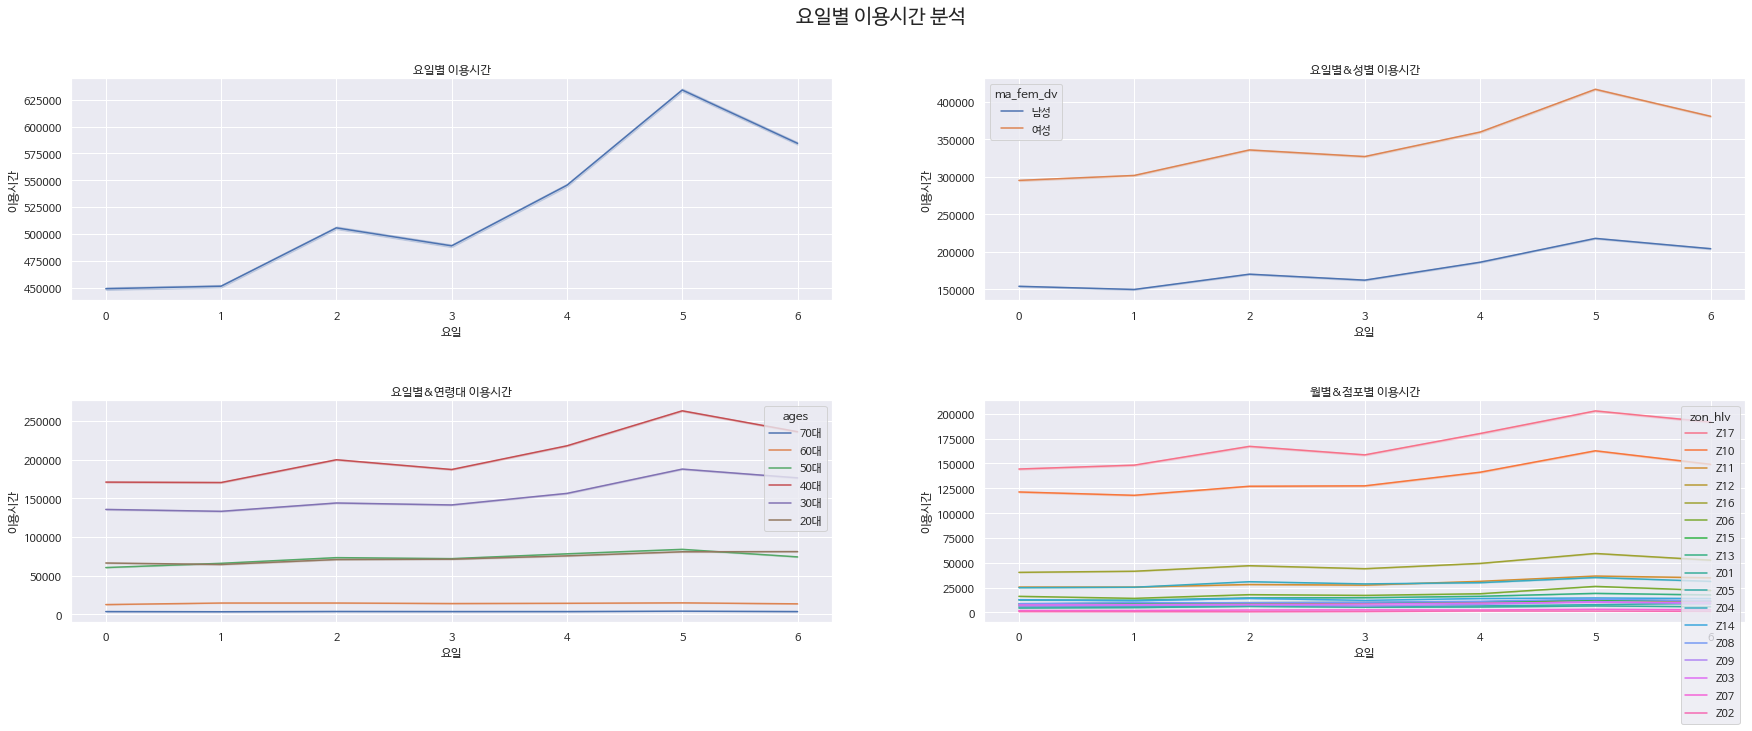

In [ ]:
# 요일별 이용시간 분석


fig, axes = plt.subplots(2,2,figsize=(30,10))
# 전체 이용시간





ax1 = sns.lineplot(data = cop_final
                ,x='요일'
                ,y='de_hr'
                ,estimator=np.sum
                #,hue = 'ma_fem_dv'
                , ax = axes[0][0]
                          )
ax1.set_title('요일별 이용시간')
ax1.set(xlabel='요일', ylabel='이용시간')


# 성별별
ax2 = sns.lineplot(data = cop_final
                ,x='요일'
                ,y='de_hr'
                ,estimator=np.sum
                ,hue = 'ma_fem_dv'
                , ax = axes[0][1]
                          )
ax2.set_title('요일별&성별 이용시간')
ax2.set(xlabel='요일', ylabel='이용시간')

# 연령대별
ax3 = sns.lineplot(data = cop_final
                ,x='요일'
                ,y='de_hr'
                ,estimator=np.sum
                ,hue = 'ages'
                , ax = axes[1][0]
                          )
ax3.set_title('요일별&연령대 이용시간')
ax3.set(xlabel='요일', ylabel='이용시간')


# 점포별
ax4 = sns.lineplot(data = cop_final
                ,x='요일'
                ,y='de_hr'
                ,estimator=np.sum
                ,hue = 'zon_hlv'
                , ax = axes[1][1]
                          )
ax4.set_title('월별&점포별 이용시간')
ax4.set(xlabel='요일', ylabel='이용시간')



plt.subplots_adjust(hspace=0.45)

plt.suptitle('요일별 이용시간 분석', fontsize=20)
plt.show()

[Text(0, 0.5, '이용시간'), Text(0.5, 0, '요일')]

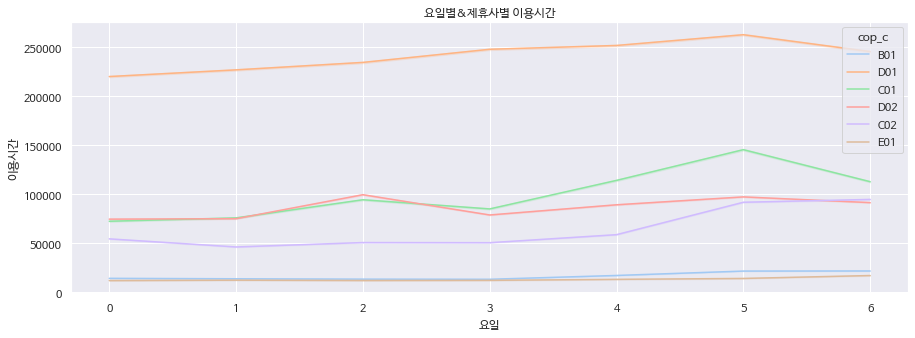

In [ ]:
plt.figure(figsize=(15,5))
ax1 = sns.lineplot(data = cop_final
                ,x='요일'
                ,y='de_hr'
                ,hue = 'cop_c'
                ,estimator=np.sum
                
                          )
ax1.set_title('요일별&제휴사별 이용시간')
ax1.set(xlabel='요일', ylabel='이용시간')


- B01: 숙박업종
- D01: F&B
- C01: 엔터테인먼트
- D02: F&B
- C02: 엔터테인먼트
- E01: 렌탈업종

# 엘페이 시각화

In [ ]:
lpay_final.columns

Index(['cust', 'rct_no', 'cop_c', 'chnl_dv', 'de_dt', 'de_hr', 'buy_am',
       'ma_fem_dv', 'ages', 'zon_hlv', '날짜', '강수량(mm)', '평균기온(℃)', '최저기온(℃)',
       '최고기온(℃)', '평균습도(%rh)', '최저습도(%rh)', '일조합(hr)', '일사합(MJ/m2)', 'year',
       'month', '요일', '일교차', '불쾌지수', 'holiday_anniversary'],
      dtype='object')

## 고객 기준별 엘페이 구매건수 확인
- 연령대별 고객수 확인
- 성별별 고객수 확인
- 거주지별 고객수 확인

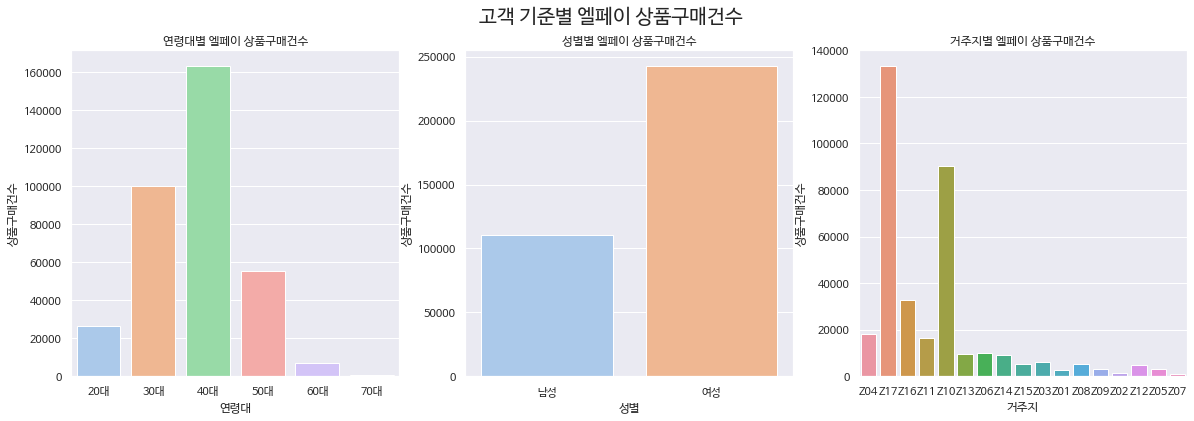

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(20,6))
sns.set_palette('pastel')
ax1= sns.countplot(x='ages',data = lpay_final,order = sorted(pdde_final['ages'].unique()), ax=axes[0] )
ax1.set_title('연령대별 엘페이 상품구매건수')
ax1.set(xlabel='연령대', ylabel='상품구매건수')

ax2=sns.countplot(x='ma_fem_dv',data = lpay_final, ax=axes[1] )
ax2.set_title('성별별 엘페이 상품구매건수')
ax2.set(xlabel='성별', ylabel='상품구매건수')

ax3=sns.countplot(x='zon_hlv',data = lpay_final, ax=axes[2] )
ax3.set_title('거주지별 엘페이 상품구매건수')
ax3.set(xlabel='거주지', ylabel='상품구매건수')

plt.suptitle('고객 기준별 엘페이 상품구매건수', fontsize=20)
plt.show()

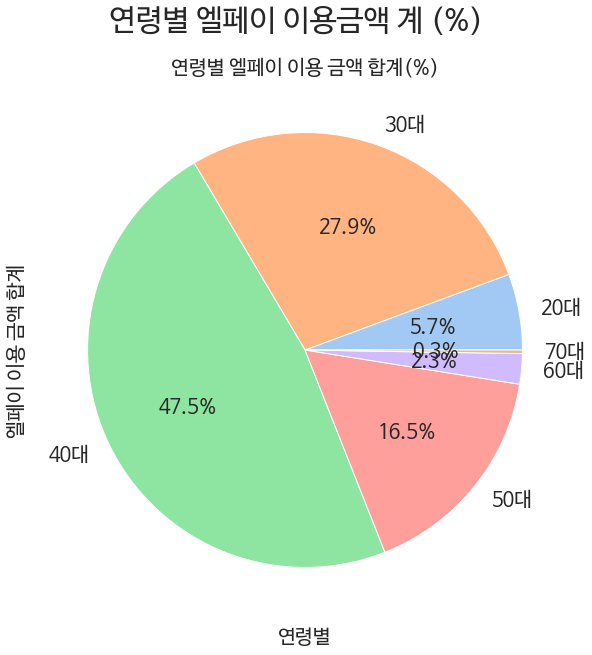

In [ ]:
color = sns.color_palette('pastel')[:10]

b= lpay_final.groupby("ages")["buy_am"].sum()

plt.figure(figsize = (10, 10))


plt.title("연령별 엘페이 이용 금액 합계(%)", fontsize=20)

b.plot(kind = 'pie', autopct='%1.1f%%',textprops= {'fontsize' : 20}, colors = color)
plt.xlabel('연령별', fontsize=20)
plt.ylabel('엘페이 이용 금액 합계', fontsize=20)

plt.suptitle('연령별 엘페이 이용금액 계 (%)', fontsize = 30)
plt.show()

## 구매일자별 확인
- 연도는 2021년으로 고정돼있다.
- 월별 분석
- 요일별 분석(0이 월요일, 6이 일요일)

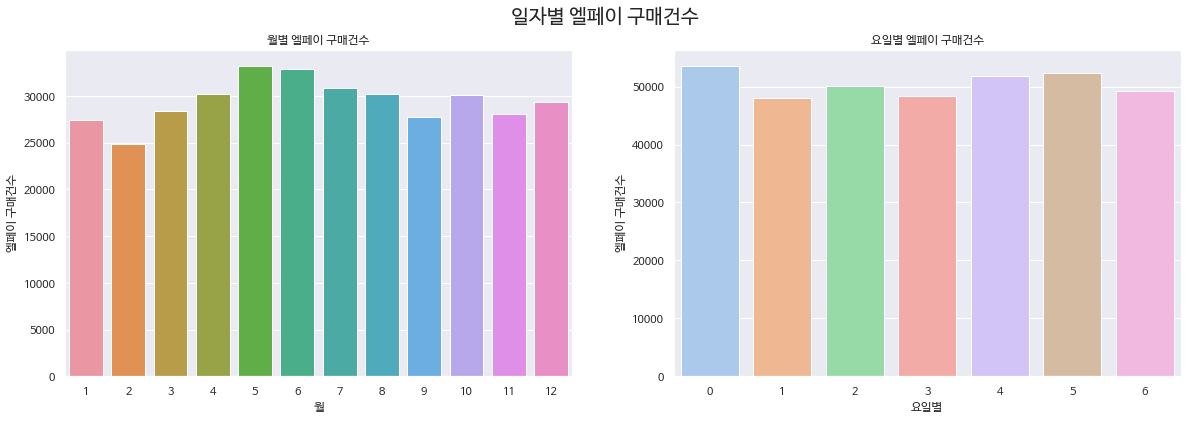

In [ ]:
# 일자별 상품구매건수 확인
fig, axes = plt.subplots(1,2,figsize=(20,6))
# ax1= sns.countplot(x='year',data = pdde,order = sorted(pdde['year'].unique()), ax=axes[0] )
# ax1.set_title('연도별 상품구매건수')
# ax1.set(xlabel='연도', ylabel='상품구매건수')

ax2=sns.countplot(x='month',data = lpay_final,order = sorted(pdde_final['month'].unique()), ax=axes[0] )
ax2.set_title('월별 엘페이 구매건수')
ax2.set(xlabel='월', ylabel='엘페이 구매건수')

ax3=sns.countplot(x='요일',data = lpay_final,order = sorted(pdde_final['요일'].unique()), ax=axes[1] )
ax3.set_title('요일별 엘페이 구매건수')
ax3.set(xlabel='요일별', ylabel='엘페이 구매건수')

plt.suptitle('일자별 엘페이 구매건수', fontsize=20)
plt.show()

<pre>
- 5월, 6월에 엘페이를 빈번하게 이용
- 2월에 가장 엘페이 사용건수가 낮다.

- 월요일에 가장 엘페이를 빈번하게 이용한다.

### 월별 분석

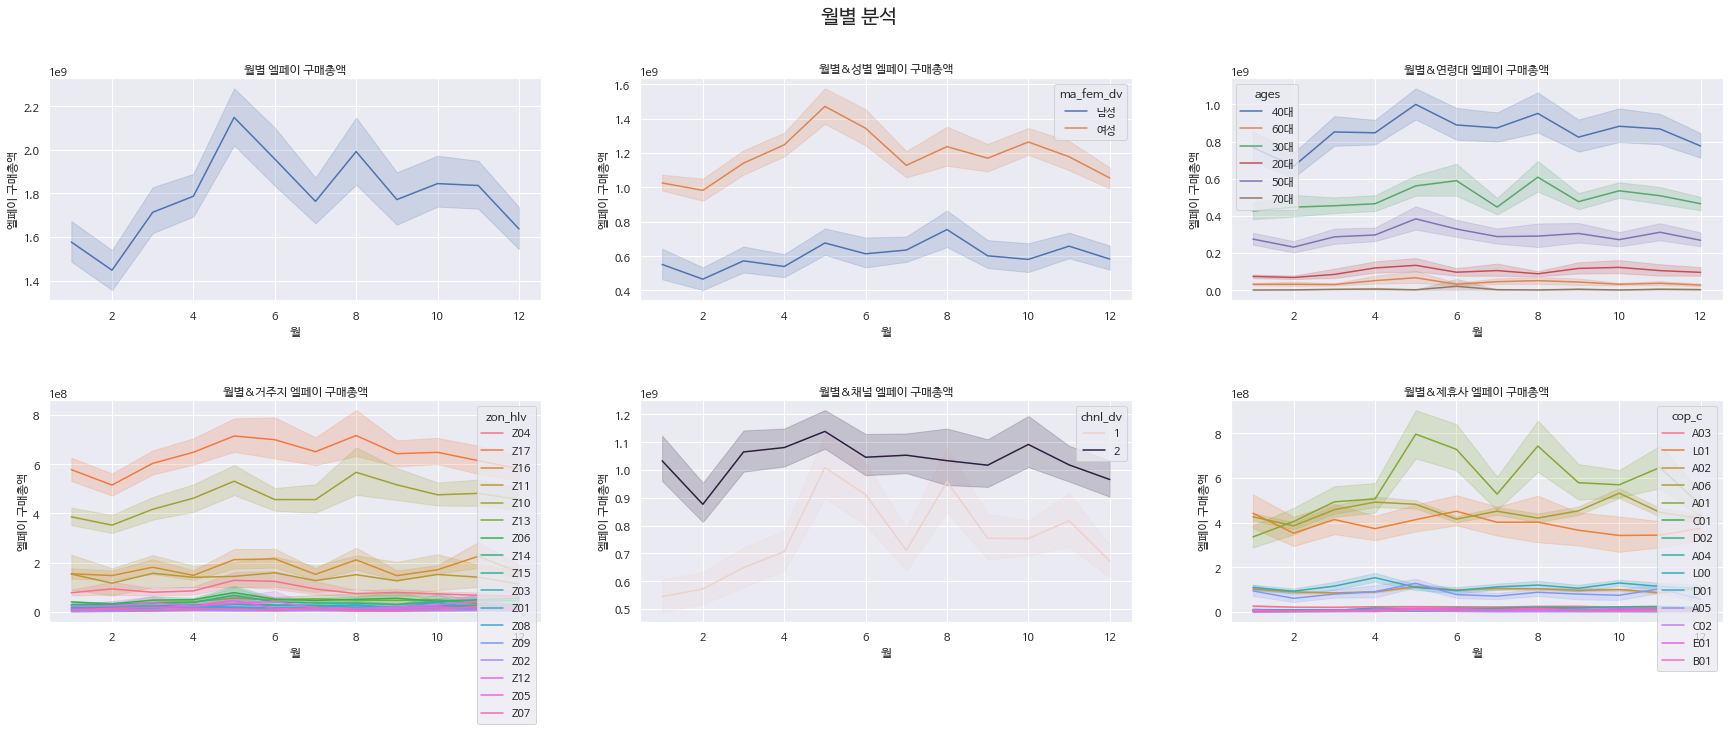

In [ ]:
# 월별 데이터 분석


fig, axes = plt.subplots(2,3,figsize=(30,10))
# 전체 매출액





ax1 = sns.lineplot(data = lpay_final
                ,x='month'
                ,y='buy_am'
                ,estimator=np.sum
                #,hue = 'ma_fem_dv'
                , ax = axes[0][0]
                          )
ax1.set_title('월별 엘페이 구매총액')
ax1.set(xlabel='월', ylabel='엘페이 구매총액')


# 성별별
ax2 = sns.lineplot(data = lpay_final
                ,x='month'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'ma_fem_dv'
                , ax = axes[0][1]
                          )
ax2.set_title('월별&성별 엘페이 구매총액')
ax2.set(xlabel='월', ylabel='엘페이 구매총액')

# 연령대별
ax3 = sns.lineplot(data = lpay_final
                ,x='month'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'ages'
                , ax = axes[0][2]
                          )
ax3.set_title('월별&연령대 엘페이 구매총액')
ax3.set(xlabel='월', ylabel='엘페이 구매총액')


# 거주지별
ax4 = sns.lineplot(data = lpay_final
                ,x='month'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'zon_hlv'
                , ax = axes[1][0]
                          )
ax4.set_title('월별&거주지 엘페이 구매총액')
ax4.set(xlabel='월', ylabel='엘페이 구매총액')

# 채널별
ax5 = sns.lineplot(data = lpay_final
                ,x='month'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'chnl_dv'
                , ax = axes[1][1]
                          )
ax5.set_title('월별&채널 엘페이 구매총액')
ax5.set(xlabel='월', ylabel='엘페이 구매총액')


# 제휴사별
ax6 = sns.lineplot(data = lpay_final
                ,x='month'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'cop_c'
                , ax = axes[1][2]
                          )
ax6.set_title('월별&제휴사 엘페이 구매총액')
ax6.set(xlabel='월', ylabel='엘페이 구매총액')



plt.subplots_adjust(hspace=0.45)

plt.suptitle('월별 분석', fontsize=20)
plt.show()

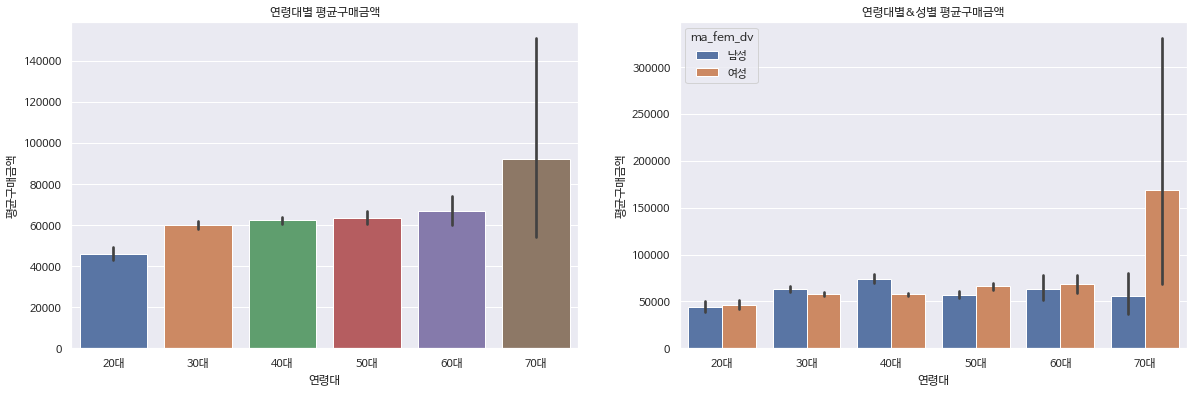

In [ ]:
color = sns.color_palette('pastel')
fig, axes = plt.subplots(1,2,figsize=(20,6))
ax1= sns.barplot(x='ages',y= 'buy_am',data = lpay_final,order = sorted(lpay_final['ages'].unique()),ax=axes[0] )
ax1.set_title('연령대별 평균구매금액')
ax1.set(xlabel='연령대', ylabel='평균구매금액')

ax2=sns.barplot(x='ages',y= 'buy_am', data = lpay_final,order = sorted(lpay_final['ages'].unique()),hue = 'ma_fem_dv', ax=axes[1] )
ax2.set_title('연령대별&성별 평균구매금액')
ax2.set(xlabel='연령대', ylabel='평균구매금액')

# sns.barplot(data = pdde
#                 ,x='ages'
#                 ,y='buy_am'
                
#                 ,hue = 'ma_fem_dv'
#                 ,order = sorted(pdde['ages'].unique())
#                          )
plt.show()

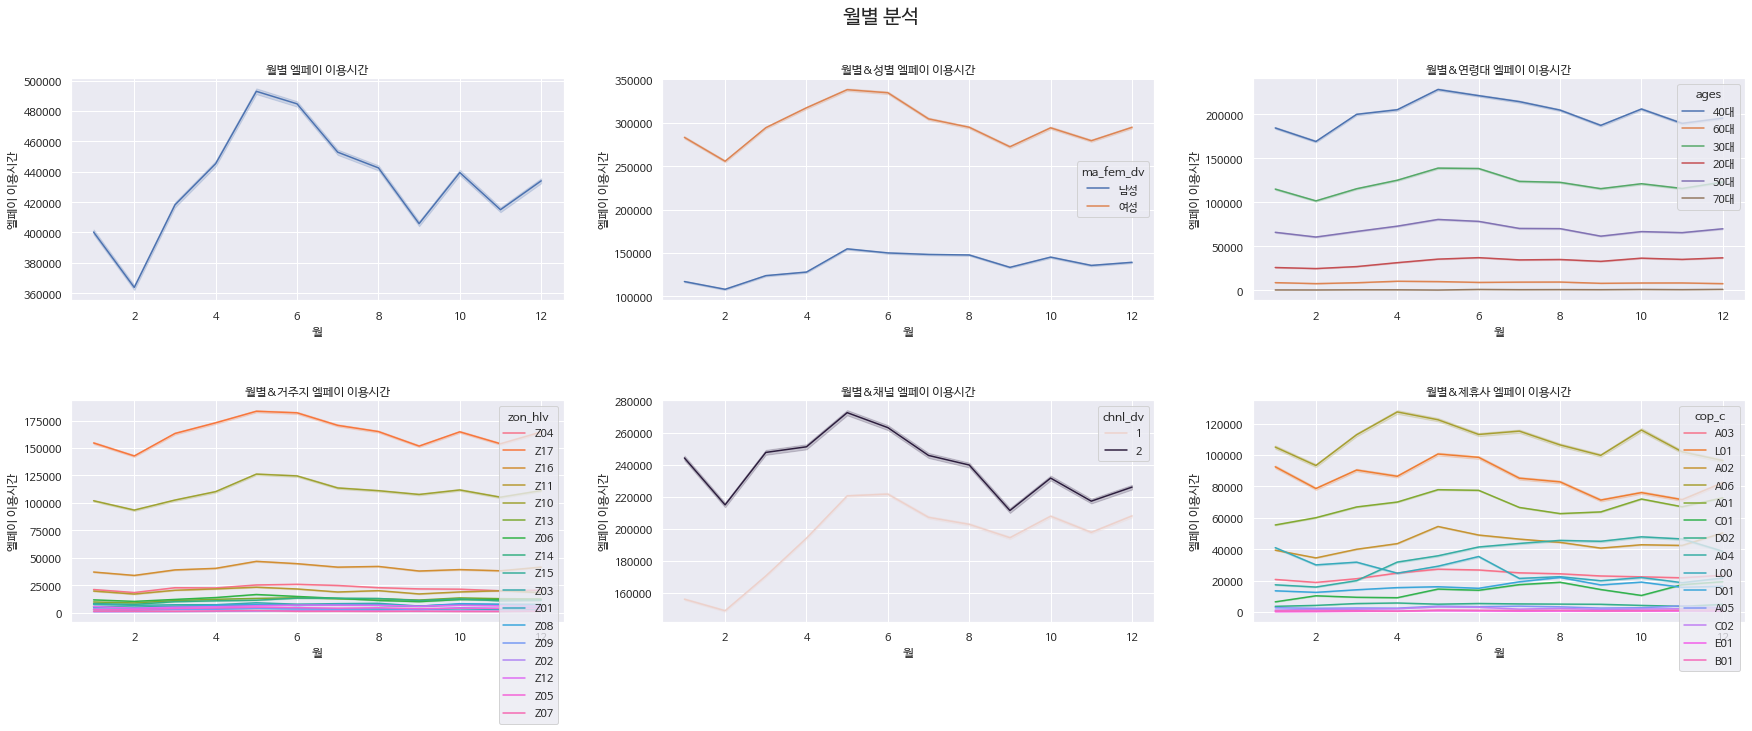

In [ ]:
# 월별 데이터 분석


fig, axes = plt.subplots(2,3,figsize=(30,10))
# 전체 이용시간





ax1 = sns.lineplot(data = lpay_final
                ,x='month'
                ,y='de_hr'
                ,estimator=np.sum
                #,hue = 'ma_fem_dv'
                , ax = axes[0][0]
                          )
ax1.set_title('월별 엘페이 이용시간')
ax1.set(xlabel='월', ylabel='엘페이 이용시간')


# 성별별
ax2 = sns.lineplot(data = lpay_final
                ,x='month'
                ,y='de_hr'
                ,estimator=np.sum
                ,hue = 'ma_fem_dv'
                , ax = axes[0][1]
                          )
ax2.set_title('월별&성별 엘페이 이용시간')
ax2.set(xlabel='월', ylabel='엘페이 이용시간')

# 연령대별
ax3 = sns.lineplot(data = lpay_final
                ,x='month'
                ,y='de_hr'
                ,estimator=np.sum
                ,hue = 'ages'
                , ax = axes[0][2]
                          )
ax3.set_title('월별&연령대 엘페이 이용시간')
ax3.set(xlabel='월', ylabel='엘페이 이용시간')


# 거주지별
ax4 = sns.lineplot(data = lpay_final
                ,x='month'
                ,y='de_hr'
                ,estimator=np.sum
                ,hue = 'zon_hlv'
                , ax = axes[1][0]
                          )
ax4.set_title('월별&거주지 엘페이 이용시간')
ax4.set(xlabel='월', ylabel='엘페이 이용시간')

# 채널별
ax5 = sns.lineplot(data = lpay_final
                ,x='month'
                ,y='de_hr'
                ,estimator=np.sum
                ,hue = 'chnl_dv'
                , ax = axes[1][1]
                          )
ax5.set_title('월별&채널 엘페이 이용시간')
ax5.set(xlabel='월', ylabel='엘페이 이용시간')


# 제휴사별
ax6 = sns.lineplot(data = lpay_final
                ,x='month'
                ,y='de_hr'
                ,estimator=np.sum
                ,hue = 'cop_c'
                , ax = axes[1][2]
                          )
ax6.set_title('월별&제휴사 엘페이 이용시간')
ax6.set(xlabel='월', ylabel='엘페이 이용시간')



plt.subplots_adjust(hspace=0.45)

plt.suptitle('월별 분석', fontsize=20)
plt.show()

### 요일별 분석

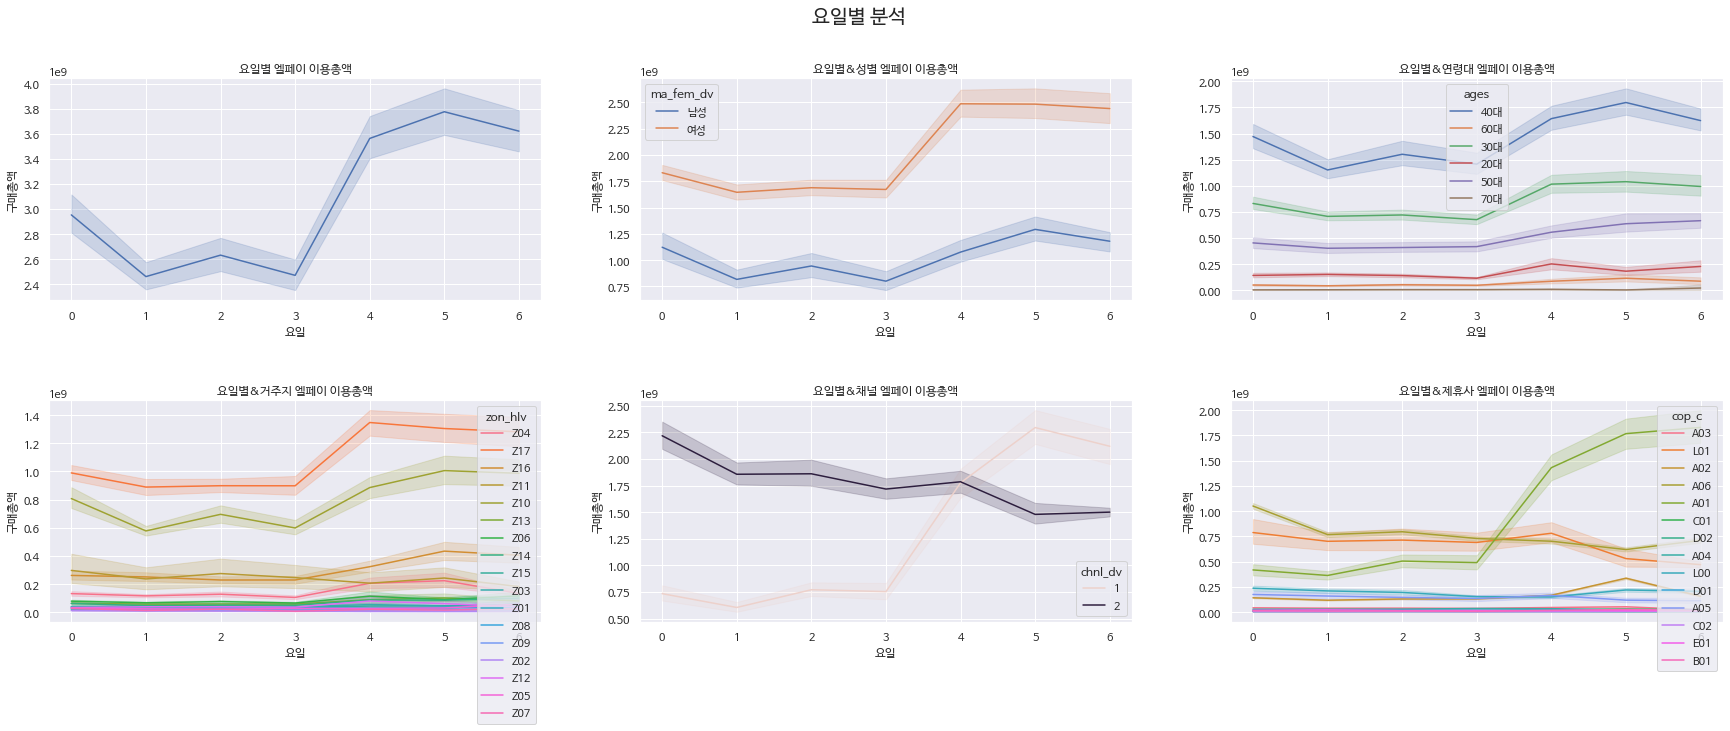

In [ ]:
# 요일별 데이터 분석


fig, axes = plt.subplots(2,3,figsize=(30,10))
# 전체 매출액





ax1 = sns.lineplot(data = lpay_final
                ,x='요일'
                ,y='buy_am'
                ,estimator=np.sum
                #,hue = 'ma_fem_dv'
                , ax = axes[0][0]
                          )
ax1.set_title('요일별 엘페이 이용총액')
ax1.set(xlabel='요일', ylabel='구매총액')


# 성별별
ax2 = sns.lineplot(data = lpay_final
                ,x='요일'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'ma_fem_dv'
                , ax = axes[0][1]
                          )
ax2.set_title('요일별&성별 엘페이 이용총액')
ax2.set(xlabel='요일', ylabel='구매총액')

# 연령대별
ax3 = sns.lineplot(data = lpay_final
                ,x='요일'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'ages'
                , ax = axes[0][2]
                          )
ax3.set_title('요일별&연령대 엘페이 이용총액')
ax3.set(xlabel='요일', ylabel='구매총액')


# 거주지별
ax4 = sns.lineplot(data = lpay_final
                ,x='요일'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'zon_hlv'
                , ax = axes[1][0]
                          )
ax4.set_title('요일별&거주지 엘페이 이용총액')
ax4.set(xlabel='요일', ylabel='구매총액')

# 채널별
ax5 = sns.lineplot(data = lpay_final
                ,x='요일'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'chnl_dv'
                , ax = axes[1][1]
                          )
ax5.set_title('요일별&채널 엘페이 이용총액')
ax5.set(xlabel='요일', ylabel='구매총액')


# 제휴사별
ax6 = sns.lineplot(data = lpay_final
                ,x='요일'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'cop_c'
                , ax = axes[1][2]
                          )
ax6.set_title('요일별&제휴사 엘페이 이용총액')
ax6.set(xlabel='요일', ylabel='구매총액')


plt.subplots_adjust(hspace=0.45)

plt.suptitle('요일별 분석', fontsize=20)
plt.show()

- 엘페이 이용총액은 다른 상품구매와 제휴사 이용건수와 다르게 금요일부터 많다.
- 엘페이 이용총액 채널별로 보면 금요일을 기점으로 뒤바뀐다.

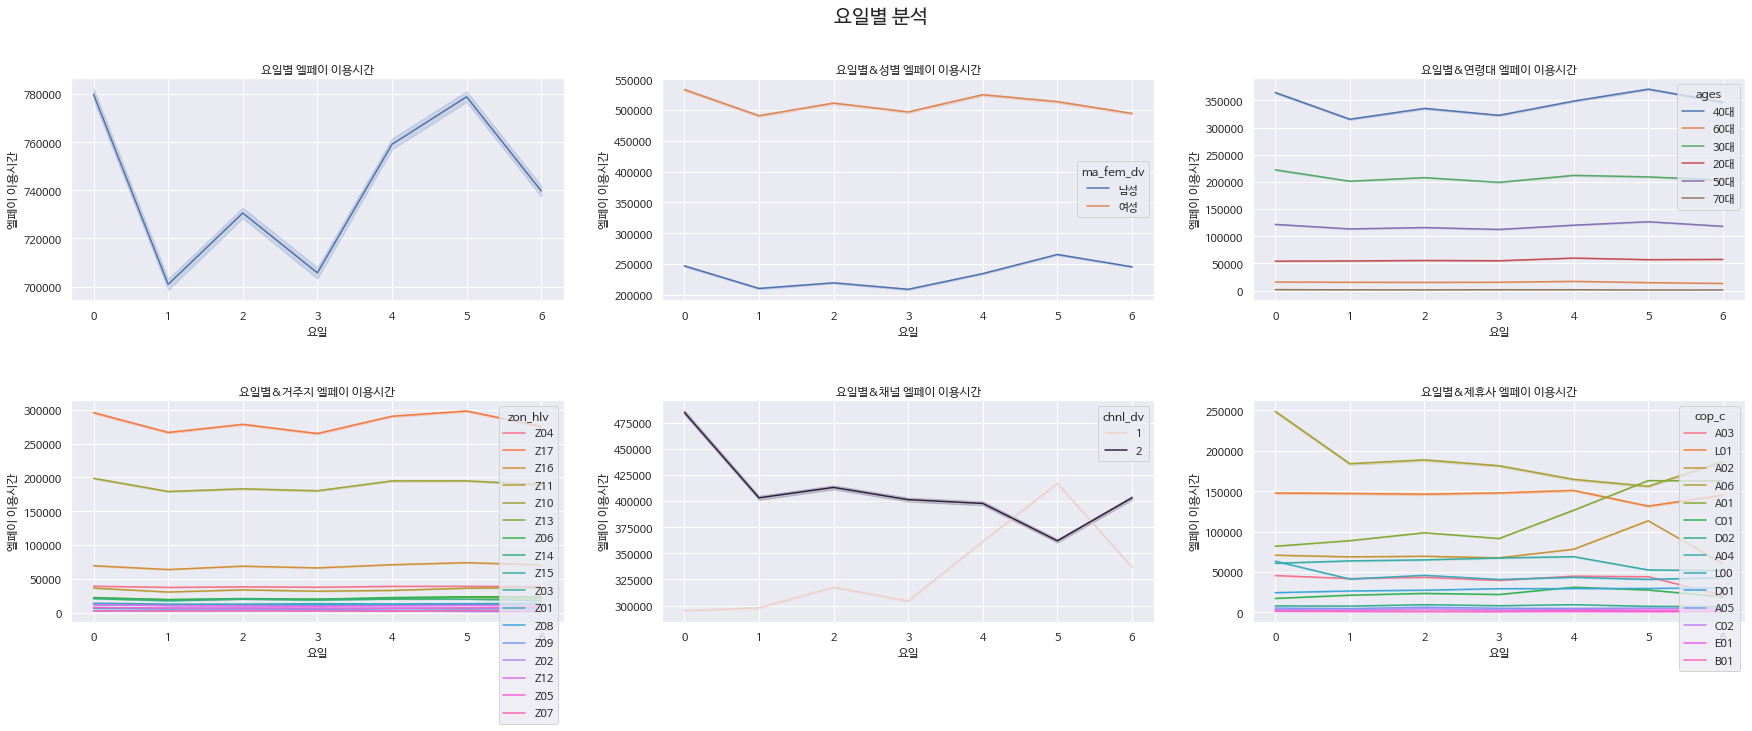

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(30,10))
# 전체 이용시간





ax1 = sns.lineplot(data = lpay_final
                ,x='요일'
                ,y='de_hr'
                ,estimator=np.sum
                #,hue = 'ma_fem_dv'
                , ax = axes[0][0]
                          )
ax1.set_title('요일별 엘페이 이용시간')
ax1.set(xlabel='요일', ylabel='엘페이 이용시간')


# 성별별
ax2 = sns.lineplot(data = lpay_final
                ,x='요일'
                ,y='de_hr'
                ,estimator=np.sum
                ,hue = 'ma_fem_dv'
                , ax = axes[0][1]
                          )
ax2.set_title('요일별&성별 엘페이 이용시간')
ax2.set(xlabel='요일', ylabel='엘페이 이용시간')

# 연령대별
ax3 = sns.lineplot(data = lpay_final
                ,x='요일'
                ,y='de_hr'
                ,estimator=np.sum
                ,hue = 'ages'
                , ax = axes[0][2]
                          )
ax3.set_title('요일별&연령대 엘페이 이용시간')
ax3.set(xlabel='요일', ylabel='엘페이 이용시간')


# 거주지별
ax4 = sns.lineplot(data = lpay_final
                ,x='요일'
                ,y='de_hr'
                ,estimator=np.sum
                ,hue = 'zon_hlv'
                , ax = axes[1][0]
                          )
ax4.set_title('요일별&거주지 엘페이 이용시간')
ax4.set(xlabel='요일', ylabel='엘페이 이용시간')

# 채널별
ax5 = sns.lineplot(data = lpay_final
                ,x='요일'
                ,y='de_hr'
                ,estimator=np.sum
                ,hue = 'chnl_dv'
                , ax = axes[1][1]
                          )
ax5.set_title('요일별&채널 엘페이 이용시간')
ax5.set(xlabel='요일', ylabel='엘페이 이용시간')


# 제휴사별
ax6 = sns.lineplot(data = lpay_final
                ,x='요일'
                ,y='de_hr'
                ,estimator=np.sum
                ,hue = 'cop_c'
                , ax = axes[1][2]
                          )
ax6.set_title('요일별&제휴사 엘페이 이용시간')
ax6.set(xlabel='요일', ylabel='엘페이 이용시간')



plt.subplots_adjust(hspace=0.45)

plt.suptitle('요일별 분석', fontsize=20)
plt.show()